<a href="https://colab.research.google.com/github/NatP-dev/Case_06/blob/main/Monthly_Interest_Rates_Data_Analysis_02062025_0837.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Monthly Interest Rates**

#### **Authors**: Group 7
- Nathalia Pouroullis
- Egon Soontiëns
- Isa Widdershoven
- Max Thönissen


In [1]:
# #------------------------------EXPORT AS HTML-----------------#
# !jupyter nbconvert --to html /content/Monthly_Interest_Rates_Data_Analysis_28052025_2040.ipynb

[NbConvertApp] Converting notebook /content/Monthly_Interest_Rates_Data_Analysis_28052025_2040.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 42 image(s).
[NbConvertApp] Writing 5343277 bytes to /content/Monthly_Interest_Rates_Data_Analysis_28052025_2040.html


## **<font color='#474747'>0 - Imports**</font>



In [ ]:
################################ LIBRARIES ########################
# -------------------------- Core Libraries -------------------------- #
import os
import pandas as pd
import re
from IPython.display import display
import numpy as np


# -------------------------- Plotting -------------------------- #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import zscore
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, Easter, GoodFriday, EasterMonday
from datetime import date, timedelta
from dateutil.easter import easter




---
---
<br><br>
# **<font color='#000058'>Chapter 1: Data</font>**



## **<font color='#474747'>1.1 - Load All Data Files**

In [ ]:
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Set the path to your folder containing the 31 CSV files
# Replace this path with the actual folder path inside your Drive
folder_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/Interest Rates/Monthly'


In [ ]:
# Step 3: Load all CSV files into a list of DataFrames
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Optional: Sort filenames to maintain a consistent order
csv_files.sort()

In [ ]:
# Step 4: Read all CSV files
dataframes = []
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes.append(df)

# Now `dataframes` is a list of 31 DataFrames (one per CSV)
# Example: access the first DataFrame
print(dataframes[0].head())

          Unnamed: 0 BBSIS.M.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A  \
0                NaN  Term structure of interest rates on listed Fed...      
1           Decimals                                                  2      
2   Time format code                                                P1M      
3  Unit (in english)                                            percent      
4           category                                               GKZR      

   BBSIS.M.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A_FLAGS  
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            


In [ ]:
# Loop for files into their own dataframes
for i in range(len(dataframes)):
    print(f"DataFrame {i}: {csv_files[i]}")

DataFrame 0: monthly-term-structure-spot-interest-rate-R005X.csv
DataFrame 1: monthly-term-structure-spot-interest-rate-R01XX.csv
DataFrame 2: monthly-term-structure-spot-interest-rate-R02XX.csv
DataFrame 3: monthly-term-structure-spot-interest-rate-R03XX.csv
DataFrame 4: monthly-term-structure-spot-interest-rate-R04XX.csv
DataFrame 5: monthly-term-structure-spot-interest-rate-R05XX.csv
DataFrame 6: monthly-term-structure-spot-interest-rate-R06XX.csv
DataFrame 7: monthly-term-structure-spot-interest-rate-R07XX.csv
DataFrame 8: monthly-term-structure-spot-interest-rate-R08XX.csv
DataFrame 9: monthly-term-structure-spot-interest-rate-R09XX.csv
DataFrame 10: monthly-term-structure-spot-interest-rate-R10XX.csv
DataFrame 11: monthly-term-structure-spot-interest-rate-R11XX.csv
DataFrame 12: monthly-term-structure-spot-interest-rate-R12XX.csv
DataFrame 13: monthly-term-structure-spot-interest-rate-R13XX.csv
DataFrame 14: monthly-term-structure-spot-interest-rate-R14XX.csv
DataFrame 15: monthl

### **<font color='#474747'>*1.1 - Format Dataframes Consistently*</font>**
What was done to format the files:
1. Start at row 11
2. Have no headers
3. Rename columns:
  * Column 1: Date (convert to datetime)
  * Column 2: Value (float, 2 decimals)
  * Column 3: Info message like "No value available"
4. Add a new column FileReferenceName with the filename.



In [ ]:
# Step 5: Read all CSVs from row 11 onward, format consistently
dataframes = []

for file in csv_files:
    full_path = os.path.join(folder_path, file)

    df = pd.read_csv(full_path, skiprows=9, header=None, dtype=str, encoding='utf-8')
    df.columns = ["Date", "Interest Rate", "Information No IR"]

    # Clean and parse columns
    df["Date"] = df["Date"].str.strip()
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m", errors="coerce")
    df["Interest Rate"] = pd.to_numeric(df["Interest Rate"], errors="coerce")
    df["FileReferenceName"] = file

    dataframes.append(df)

# Adjust maturity assignment, with special handling for R005X
for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]

    if "R005X" in file_name:
        df["Maturity"] = 0.5
    else:
        match = re.search(r"R(\d{2})X", file_name)
        if match:
            df["Maturity"] = int(match.group(1))  # e.g., R01XX → 1
        else:
            df["Maturity"] = None  # fallback


In [ ]:
# CHECK DATA MANUALLY (Ensure alignment with excels)
# Head
display(dataframes[0].head(5))

# Tail
display(dataframes[0].tail(5))

Date  Interest Rate Information No IR  \
0 1972-09-01          12.20               NaN   
1 1972-10-01           6.86               NaN   
2 1972-11-01          13.64               NaN   
3 1972-12-01           5.26               NaN   
4 1973-01-01           6.18               NaN   

                                   FileReferenceName  Maturity  
0  monthly-term-structure-spot-interest-rate-R005...       0.5  
1  monthly-term-structure-spot-interest-rate-R005...       0.5  
2  monthly-term-structure-spot-interest-rate-R005...       0.5  
3  monthly-term-structure-spot-interest-rate-R005...       0.5  
4  monthly-term-structure-spot-interest-rate-R005...       0.5

Date  Interest Rate Information No IR  \
627 2024-12-01           2.37               NaN   
628 2025-01-01           2.32               NaN   
629 2025-02-01           2.19               NaN   
630 2025-03-01           2.10               NaN   
631 2025-04-01           1.87               NaN   

                                     FileReferenceName  Maturity  
627  monthly-term-structure-spot-interest-rate-R005...       0.5  
628  monthly-term-structure-spot-interest-rate-R005...       0.5  
629  monthly-term-structure-spot-interest-rate-R005...       0.5  
630  monthly-term-structure-spot-interest-rate-R005...       0.5  
631  monthly-term-structure-spot-interest-rate-R005...       0.5

## **<font color='#474747'>1.2 - Data Pre-processing**

In [ ]:
### INFORMATION ON DATA PER FILE
# Collect info summary per DataFrame
summary_rows = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]  # Use the already existing numeric Maturity value
    row = {"Maturity": maturity, "Rows": len(df)}

    for col in df.columns:
        row[f"{col} | Non-Null"] = df[col].notnull().sum()
        row[f"{col} | Dtype"] = str(df[col].dtype)

    summary_rows.append(row)

# Create summary table
summary_df = pd.DataFrame(summary_rows)
summary_df.set_index("Maturity", inplace=True)
summary_df = summary_df.sort_index()

# Display in notebook (nicely formatted)
from IPython.display import display
display(summary_df)


Rows  Date | Non-Null    Date | Dtype  Interest Rate | Non-Null  \
Maturity                                                                    
0.5        632              632  datetime64[ns]                       632   
1.0        632              632  datetime64[ns]                       632   
2.0        632              632  datetime64[ns]                       632   
3.0        632              632  datetime64[ns]                       632   
4.0        632              632  datetime64[ns]                       632   
5.0        632              632  datetime64[ns]                       632   
6.0        632              632  datetime64[ns]                       632   
7.0        632              632  datetime64[ns]                       632   
8.0        632              632  datetime64[ns]                       632   
9.0        632              632  datetime64[ns]                       632   
10.0       632              632  datetime64[ns]                       632   
11.0       467              467  datetime64[ns]                       467   
12.0       467              467  datetime64[ns]                       467   
13.0       467              467  datetime64[ns]                       467   
14.0       467              467  datetime64[ns]                       467   
15.0       467              467  datetime64[ns]                       467   
16.0       467              467  datetime64[ns]                       467   
17.0       467              467  datetime64[ns]                       467   
18.0       467              467  datetime64[ns]                       467   
19.0       467              467  datetime64[ns]                       467   
20.0       467              467  datetime64[ns]                       467   
21.0       304              304  datetime64[ns]                       304   
22.0       304              304  datetime64[ns]                       304   
23.0       304              304  datetime64[ns]                       304   
24.0       304              304  datetime64[ns]                       304   
25.0       304              304  datetime64[ns]                       304   
26.0       304              304  datetime64[ns]                       304   
27.0       304              304  datetime64[ns]                       304   
28.0       304              304  datetime64[ns]                       304   
29.0       304              304  datetime64[ns]                       304   
30.0       304              304  datetime64[ns]                       304   

         Interest Rate | Dtype  Information No IR | Non-Null  \
Maturity                                                       
0.5                    float64                             0   
1.0                    float64                             0   
2.0                    float64                             0   
3.0                    float64                             0   
4.0                    float64                             0   
5.0                    float64                             0   
6.0                    float64                             0   
7.0                    float64                             0   
8.0                    float64                             0   
9.0                    float64                             0   
10.0                   float64                             0   
11.0                   float64                             0   
12.0                   float64                             0   
13.0                   float64                             0   
14.0                   float64                             0   
15.0                   float64                             0   
16.0                   float64                             0   
17.0                   float64                             0   
18.0                   float64                             0   
19.0                   float64                             0   
20.0                   float64                             0

In [ ]:
### DESCRIBE() DATA
for i, df in enumerate(dataframes):
    # Get file/maturity label
    file_name = df["FileReferenceName"].iloc[0]
    maturity = re.search(r"(R\d+X)", file_name).group(1)

    print(f"\n--- Summary Statistics for {maturity} ({file_name}) ---")
    print(df.describe())



--- Summary Statistics for R005X (monthly-term-structure-spot-interest-rate-R005X.csv) ---
                                Date  Interest Rate  Maturity
count                            632     632.000000     632.0
mean   1998-12-16 05:09:52.405063296       3.891646       0.5
min              1972-09-01 00:00:00      -0.920000       0.5
25%              1985-10-24 06:00:00       0.937500       0.5
50%              1998-12-16 12:00:00       3.635000       0.5
75%              2012-02-08 06:00:00       5.815000       0.5
max              2025-04-01 00:00:00      15.010000       0.5
std                              NaN       3.320588       0.0

--- Summary Statistics for R01X (monthly-term-structure-spot-interest-rate-R01XX.csv) ---
                                Date  Interest Rate  Maturity
count                            632     632.000000     632.0
mean   1998-12-16 05:09:52.405063296       3.914019       1.0
min              1972-09-01 00:00:00      -0.920000       1.0
25%        

In [ ]:
### SUMMARIZE DESCRIBE() OF INTEREST RATE VALUES INTO ONE TABLE
summary_rows = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]  # Use numeric Maturity directly

    # Get describe for Interest Rate only
    stats = df[["Interest Rate"]].describe().T  # Transpose to get single row per maturity
    stats["Maturity"] = maturity
    summary_rows.append(stats)

# Combine all rows
summary_df = pd.concat(summary_rows)
summary_df.set_index("Maturity", inplace=True)

# Round numeric output
summary_df = summary_df.round(4)

# Display as a table
from IPython.display import display
display(summary_df)


count    mean     std   min     25%    50%     75%    max
Maturity                                                           
0.5       632.0  3.8916  3.3206 -0.92  0.9375  3.635  5.8150  15.01
1.0       632.0  3.9140  3.2164 -0.92  1.1075  3.795  5.9325  13.17
2.0       632.0  4.0908  3.2062 -0.92  1.4725  4.085  6.3800  12.33
3.0       632.0  4.2729  3.2133 -0.95  1.8725  4.385  6.9200  12.00
4.0       632.0  4.4356  3.2081 -0.95  2.0600  4.615  7.0875  11.76
5.0       632.0  4.5786  3.1914 -0.93  2.2050  4.810  7.2650  11.49
6.0       632.0  4.7037  3.1665 -0.90  2.2750  5.010  7.3400  11.20
7.0       632.0  4.8125  3.1370 -0.85  2.3300  5.145  7.4400  10.90
8.0       632.0  4.9069  3.1058 -0.80  2.4300  5.230  7.4725  10.99
9.0       632.0  4.9890  3.0747 -0.76  2.4800  5.280  7.4900  11.16
10.0      632.0  5.0606  3.0451 -0.71  2.5175  5.330  7.5100  11.30
11.0      467.0  3.9885  2.6168 -0.66  1.9150  4.200  6.2700   9.19
12.0      467.0  4.0531  2.5984 -0.61  2.0450  4.280  6.3400   9.14
13.0      467.0  4.1102  2.5822 -0.57  2.1600  4.340  6.3850   9.09
14.0      467.0  4.1600  2.5680 -0.53  2.2400  4.400  6.4200   9.09
15.0      467.0  4.2036  2.5558 -0.49  2.2850  4.450  6.4800   9.09
16.0      467.0  4.2416  2.5452 -0.45  2.3300  4.490  6.5100   9.09
17.0      467.0  4.2745  2.5370 -0.42  2.3650  4.530  6.5400   9.09
18.0      467.0  4.3032  2.5297 -0.39  2.4100  4.560  6.5650   9.09
19.0      467.0  4.3276  2.5244 -0.36  2.4400  4.580  6.5800   9.10
20.0      467.0  4.3493  2.5203 -0.34  2.4500  4.600  6.6000   9.10
21.0      304.0  2.9276  1.8366 -0.32  1.1575  2.815  4.5600   6.14
22.0      304.0  2.9435  1.8369 -0.31  1.1850  2.820  4.5800   6.17
23.0      304.0  2.9563  1.8376 -0.30  1.1975  2.820  4.5825   6.21
24.0      304.0  2.9668  1.8385 -0.28  1.2200  2.810  4.5825   6.24
25.0      304.0  2.9748  1.8397 -0.27  1.2475  2.800  4.5850   6.28
26.0      304.0  2.9806  1.8411 -0.26  1.2675  2.785  4.5875   6.31
27.0      304.0  2.9849  1.8423 -0.25  1.2875  2.770  4.6025   6.35
28.0      304.0  2.9871  1.8438 -0.24  1.3000  2.745  4.6200   6.38
29.0      304.0  2.9884  1.8454 -0.23  1.3175  2.725  4.6225   6.41
30.0      304.0  2.9879  1.8475 -0.23  1.3250  2.705  4.6125   6.45

In [ ]:
# Render the first DataFrame in a pretty HTML table (good for Colab)
dataframes[0]

Date  Interest Rate Information No IR  \
0   1972-09-01          12.20               NaN   
1   1972-10-01           6.86               NaN   
2   1972-11-01          13.64               NaN   
3   1972-12-01           5.26               NaN   
4   1973-01-01           6.18               NaN   
..         ...            ...               ...   
627 2024-12-01           2.37               NaN   
628 2025-01-01           2.32               NaN   
629 2025-02-01           2.19               NaN   
630 2025-03-01           2.10               NaN   
631 2025-04-01           1.87               NaN   

                                     FileReferenceName  Maturity  
0    monthly-term-structure-spot-interest-rate-R005...       0.5  
1    monthly-term-structure-spot-interest-rate-R005...       0.5  
2    monthly-term-structure-spot-interest-rate-R005...       0.5  
3    monthly-term-structure-spot-interest-rate-R005...       0.5  
4    monthly-term-structure-spot-interest-rate-R005...       0.5  
..                                                 ...       ...  
627  monthly-term-structure-spot-interest-rate-R005...       0.5  
628  monthly-term-structure-spot-interest-rate-R005...       0.5  
629  monthly-term-structure-spot-interest-rate-R005...       0.5  
630  monthly-term-structure-spot-interest-rate-R005...       0.5  
631  monthly-term-structure-spot-interest-rate-R005...       0.5  

[632 rows x 5 columns]


### **<font color='#474747'>*1.2.1 - General Data Checks*</font>**


#### **Date Column**

In [ ]:
#-------------------------------------   MISSING DATA CHECKS - Date Column -------------------------------------#
### DATE COLUMN(S)
# Prepare results list
date_analysis = []

for df in dataframes:
    # Use Maturity column directly
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Get date column
    date_col = df["Date"]

    # Calculate required values
    min_date = date_col.min()
    max_date = date_col.max()
    total_rows = len(df)
    missing_count = date_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not datetime
    incorrectly_formatted = date_col.apply(lambda x: not isinstance(x, pd.Timestamp) and pd.notnull(x)).sum()

    # Calculate number of days between min and max date
    date_range_days = (max_date - min_date).days if pd.notnull(min_date) and pd.notnull(max_date) else None

    date_analysis.append({
        "Maturity": maturity,
        "Minimum Date": min_date,
        "Maximum Date": max_date,
        "Date Range (Days)": date_range_days,
        "Count Rows": total_rows,
        "Count Missing Dates": missing_count,
        "% Missing Dates": round(missing_pct, 2),
        "Incorrectly Formatted Data": incorrectly_formatted
    })

# Create summary DataFrame
date_summary_df = pd.DataFrame(date_analysis)
date_summary_df.set_index("Maturity", inplace=True)
date_summary_df.sort_index(inplace=True)

# Display the result
print("Date Column Analysis by Maturity")  # i.e. per file
display(date_summary_df)


Date Column Analysis by Maturity


Minimum Date Maximum Date  Date Range (Days)  Count Rows  \
Maturity                                                            
0.5        1972-09-01   2025-04-01              19205         632   
1.0        1972-09-01   2025-04-01              19205         632   
2.0        1972-09-01   2025-04-01              19205         632   
3.0        1972-09-01   2025-04-01              19205         632   
4.0        1972-09-01   2025-04-01              19205         632   
5.0        1972-09-01   2025-04-01              19205         632   
6.0        1972-09-01   2025-04-01              19205         632   
7.0        1972-09-01   2025-04-01              19205         632   
8.0        1972-09-01   2025-04-01              19205         632   
9.0        1972-09-01   2025-04-01              19205         632   
10.0       1972-09-01   2025-04-01              19205         632   
11.0       1986-06-01   2025-04-01              14184         467   
12.0       1986-06-01   2025-04-01              14184         467   
13.0       1986-06-01   2025-04-01              14184         467   
14.0       1986-06-01   2025-04-01              14184         467   
15.0       1986-06-01   2025-04-01              14184         467   
16.0       1986-06-01   2025-04-01              14184         467   
17.0       1986-06-01   2025-04-01              14184         467   
18.0       1986-06-01   2025-04-01              14184         467   
19.0       1986-06-01   2025-04-01              14184         467   
20.0       1986-06-01   2025-04-01              14184         467   
21.0       2000-01-01   2025-04-01               9222         304   
22.0       2000-01-01   2025-04-01               9222         304   
23.0       2000-01-01   2025-04-01               9222         304   
24.0       2000-01-01   2025-04-01               9222         304   
25.0       2000-01-01   2025-04-01               9222         304   
26.0       2000-01-01   2025-04-01               9222         304   
27.0       2000-01-01   2025-04-01               9222         304   
28.0       2000-01-01   2025-04-01               9222         304   
29.0       2000-01-01   2025-04-01               9222         304   
30.0       2000-01-01   2025-04-01               9222         304   

          Count Missing Dates  % Missing Dates  Incorrectly Formatted Data  
Maturity                                                                    
0.5                         0              0.0                           0  
1.0                         0              0.0                           0  
2.0                         0              0.0                           0  
3.0                         0              0.0                           0  
4.0                         0              0.0                           0  
5.0                         0              0.0                           0  
6.0                         0              0.0                           0  
7.0                         0              0.0                           0  
8.0                         0              0.0                           0  
9.0                         0              0.0                           0  
10.0                        0              0.0                           0  
11.0                        0              0.0                           0  
12.0                        0              0.0                           0  
13.0                        0              0.0                           0  
14.0                        0              0.0                           0  
15.0                        0              0.0                           0  
16.0                        0              0.0                           0  
17.0                        0              0.0                           0  
18.0                        0              0.0                           0  
19.0                        0              0.0                           0  
20.0                        0        

#### **Interest Rate Column**

In [ ]:
#-------------------------------------   MISSING DATA CHECKS - Interest Rate Column -------------------------------------#
### INTEREST RATE COLUMN(S)
# Prepare results list
ir_analysis = []

for df in dataframes:
    # Use Maturity column directly
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Get interest rate column
    ir_col = df["Interest Rate"]

    # Basic statistics
    min_ir = ir_col.min()
    max_ir = ir_col.max()
    ir_range = max_ir - min_ir if pd.notnull(min_ir) and pd.notnull(max_ir) else None
    total_rows = len(df)
    missing_count = ir_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not floats or ints
    incorrectly_formatted = ir_col.apply(lambda x: not isinstance(x, (float, int)) and pd.notnull(x)).sum()

    ir_analysis.append({
        "Maturity": maturity,
        "Minimum Interest Rate": round(min_ir, 4) if pd.notnull(min_ir) else None,
        "Maximum Interest Rate": round(max_ir, 4) if pd.notnull(max_ir) else None,
        "Interest Rate Range": round(ir_range, 4) if ir_range is not None else None,
        "Count Rows": total_rows,
        "Count Missing Interest Rates": missing_count,
        "% Missing Interest Rates": round(missing_pct, 2),
        "Incorrectly Formatted Rates": incorrectly_formatted
    })

# Create summary DataFrame
ir_summary_df = pd.DataFrame(ir_analysis)
ir_summary_df.set_index("Maturity", inplace=True)
ir_summary_df.sort_index(inplace=True)

# Display the result
print("Interest Rate Column Analysis by Maturity (Including Weekends)")
display(ir_summary_df)


Interest Rate Column Analysis by Maturity (Including Weekends)


Minimum Interest Rate  Maximum Interest Rate  Interest Rate Range  \
Maturity                                                                      
0.5                       -0.92                  15.01                15.93   
1.0                       -0.92                  13.17                14.09   
2.0                       -0.92                  12.33                13.25   
3.0                       -0.95                  12.00                12.95   
4.0                       -0.95                  11.76                12.71   
5.0                       -0.93                  11.49                12.42   
6.0                       -0.90                  11.20                12.10   
7.0                       -0.85                  10.90                11.75   
8.0                       -0.80                  10.99                11.79   
9.0                       -0.76                  11.16                11.92   
10.0                      -0.71                  11.30                12.01   
11.0                      -0.66                   9.19                 9.85   
12.0                      -0.61                   9.14                 9.75   
13.0                      -0.57                   9.09                 9.66   
14.0                      -0.53                   9.09                 9.62   
15.0                      -0.49                   9.09                 9.58   
16.0                      -0.45                   9.09                 9.54   
17.0                      -0.42                   9.09                 9.51   
18.0                      -0.39                   9.09                 9.48   
19.0                      -0.36                   9.10                 9.46   
20.0                      -0.34                   9.10                 9.44   
21.0                      -0.32                   6.14                 6.46   
22.0                      -0.31                   6.17                 6.48   
23.0                      -0.30                   6.21                 6.51   
24.0                      -0.28                   6.24                 6.52   
25.0                      -0.27                   6.28                 6.55   
26.0                      -0.26                   6.31                 6.57   
27.0                      -0.25                   6.35                 6.60   
28.0                      -0.24                   6.38                 6.62   
29.0                      -0.23                   6.41                 6.64   
30.0                      -0.23                   6.45                 6.68   

          Count Rows  Count Missing Interest Rates  % Missing Interest Rates  \
Maturity                                                                       
0.5              632                             0                       0.0   
1.0              632                             0                       0.0   
2.0              632                             0                       0.0   
3.0              632                             0                       0.0   
4.0              632                             0                       0.0   
5.0              632                             0                       0.0   
6.0              632                             0                       0.0   
7.0              632                             0                       0.0   
8.0              632                             0                       0.0   
9.0              632                             0                       0.0   
10.0             632                             0                       0.0   
11.0             467                             0                       0.0   
12.0             467                             0                       0.0   
13.0             467                             0                       0.0   
14.0             467                             0                       0.0   
15.0             467                      

The above missing data is clearly quite high (sitting around 30%). The reason for this being primarily due to weekends and public holidays.

### **<font color='#474747'>*1.2.2 - Outlier Analysis (Extreme Values)*</font>**

#### **Date Column**

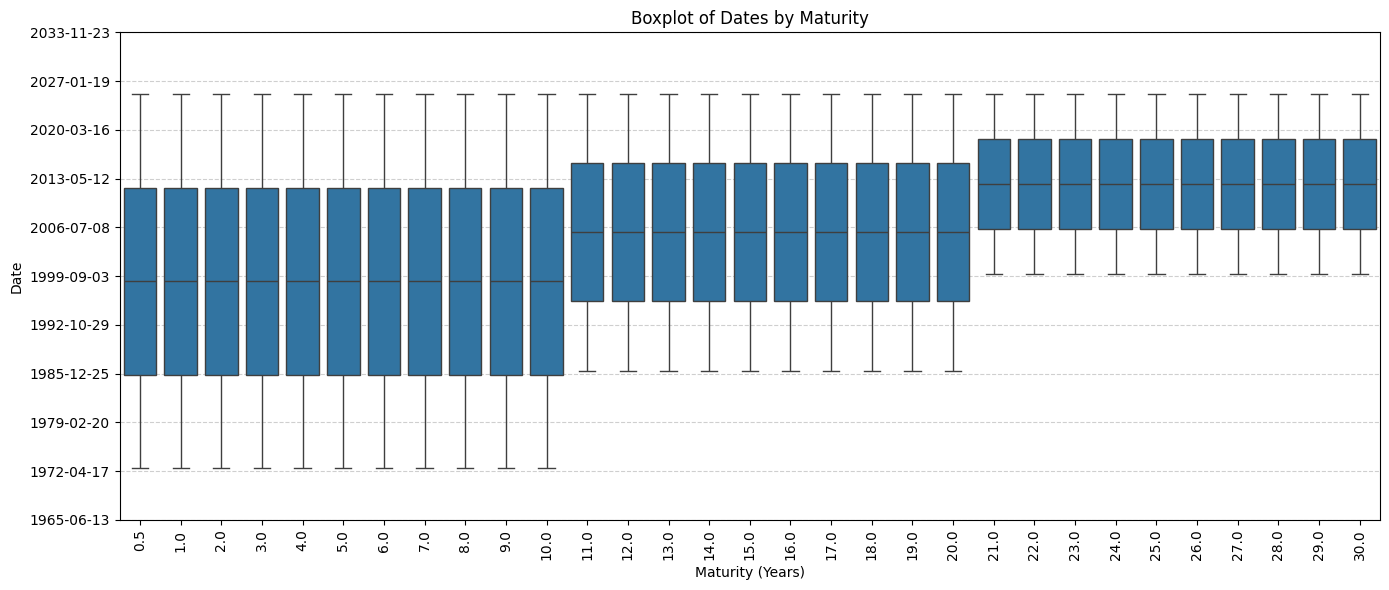

In [ ]:
#-------------------------------------   OUTLIER ANALYSIS - Date Column -------------------------------------#

# Prepare long-format date data for seaborn boxplot
date_long_df = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    for date in df["Date"].dropna():
        date_long_df.append({"Maturity": maturity, "Date": date})

# Create DataFrame
df_plot_date = pd.DataFrame(date_long_df)

# Convert datetime to ordinal for boxplot
df_plot_date["DateOrdinal"] = df_plot_date["Date"].map(pd.Timestamp.toordinal)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_date, x="Maturity", y="DateOrdinal", showfliers=False)
plt.title("Boxplot of Dates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Date")
plt.xticks(rotation=90)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Format y-axis back from ordinal to readable dates
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels=[pd.Timestamp.fromordinal(int(d)).strftime('%Y-%m-%d') for d in locs])

plt.tight_layout()
plt.show()


#### **Interest Rate Column**

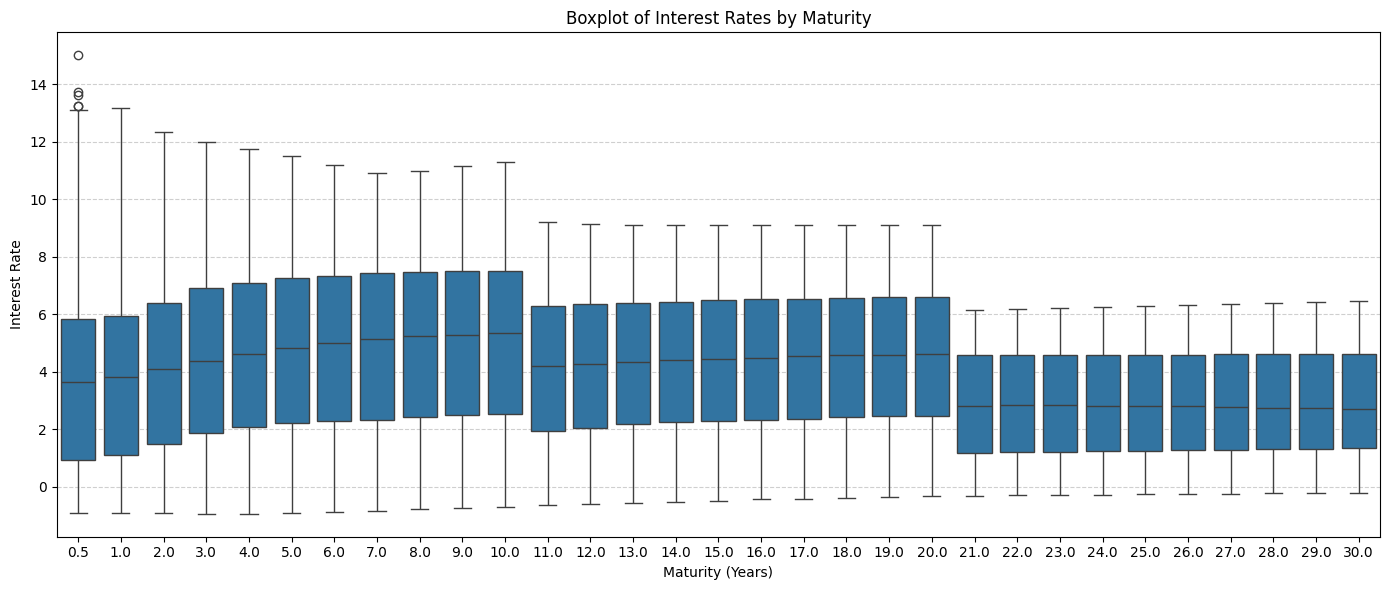

In [ ]:
#-------------------------------------- OUTLIER ANALYSIS - Interest Rate Column ---------------------------------------#

from scipy.stats import zscore

# Collect interest rate data
ir_long_df = []
outlier_counts_iqr = {}
outlier_counts_z = {}

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None
    series = df["Interest Rate"].dropna()

    if len(series) < 10:
        continue

    # Append to long-format DataFrame list
    ir_long_df.extend([{"Maturity": maturity, "Interest Rate": val} for val in series])

    # IQR outliers
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_iqr = series[(series < lower) | (series > upper)]
    outlier_counts_iqr[maturity] = len(outliers_iqr)

    # Z-score outliers
    z_scores = zscore(series)
    outliers_z = series[(z_scores > 3) | (z_scores < -3)]
    outlier_counts_z[maturity] = len(outliers_z)

# Convert long-format data
df_plot_ir = pd.DataFrame(ir_long_df)

# Create boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_ir, x="Maturity", y="Interest Rate", showfliers=True)
plt.title("Boxplot of Interest Rates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Interest Rate")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# #--------------------- Outlier Summary: IQR & Z-Score ---------------------#
# outlier_summary_df = pd.DataFrame({
#     "Maturity": list(outlier_counts_iqr.keys()),
#     "Total Outliers (IQR)": list(outlier_counts_iqr.values()),
#     "Total Outliers (Z-Score)": [outlier_counts_z.get(k, 0) for k in outlier_counts_iqr.keys()]
# }).sort_values("Maturity").set_index("Maturity")

# print("#--------------------- Outlier Summary: Interest Rate ---------------------#")
# display(outlier_summary_df)

# # Plot histogram of IQR outliers
# plt.figure(figsize=(12, 5))
# sns.barplot(x=outlier_summary_df.index, y=outlier_summary_df["Total Outliers (IQR)"], palette="coolwarm")
# plt.title("Outliers in Interest Rates (IQR Method)")
# plt.xlabel("Maturity")
# plt.ylabel("Outlier Count")
# plt.grid(True, axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


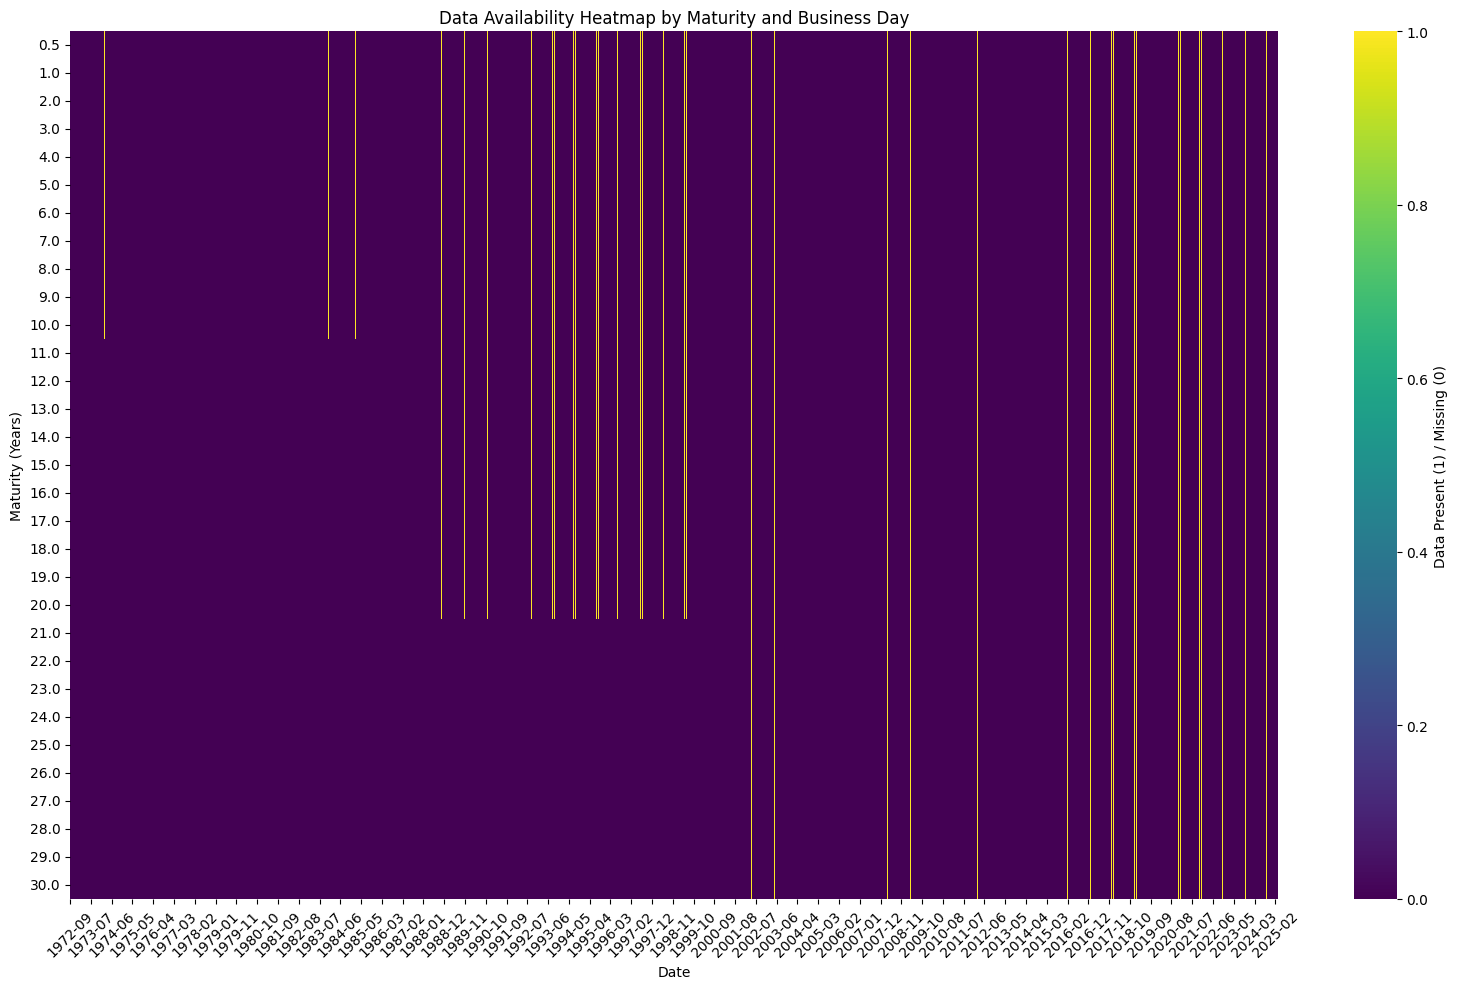

In [ ]:
#--------------------- Data Availability Heatmap by Maturity and Month ---------------------#

# Prepare date range covering all files
all_dates = pd.date_range(
    start=min(df['Date'].min() for df in dataframes),
    end=max(df['Date'].max() for df in dataframes),
    freq='B'  # Business days only
)

# Initialize empty DataFrame with dates as index
heatmap_df = pd.DataFrame(index=all_dates)

# Populate matrix with availability per maturity (1 = data present, 0 = missing)
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[['Date', 'Interest Rate']].copy()
    temp['HasData'] = temp['Interest Rate'].notna().astype(int)
    temp.set_index('Date', inplace=True)
    temp = temp.reindex(all_dates, fill_value=0)
    heatmap_df[maturity] = temp['HasData']

# Reorder rows by maturity
heatmap_df = heatmap_df.T.sort_index()

# Format ticks for two per year
xtick_positions = range(0, len(heatmap_df.columns), int(len(heatmap_df.columns) / ((2025 - 1997 + 1) * 2)))
xtick_labels = [heatmap_df.columns[i].strftime('%Y-%m') for i in xtick_positions]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_df, cmap='viridis', cbar_kws={'label': 'Data Present (1) / Missing (0)'})
plt.title('Data Availability Heatmap by Maturity and Business Day')
plt.xlabel('Date')
plt.ylabel('Maturity (Years)')
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.tight_layout()
plt.show()


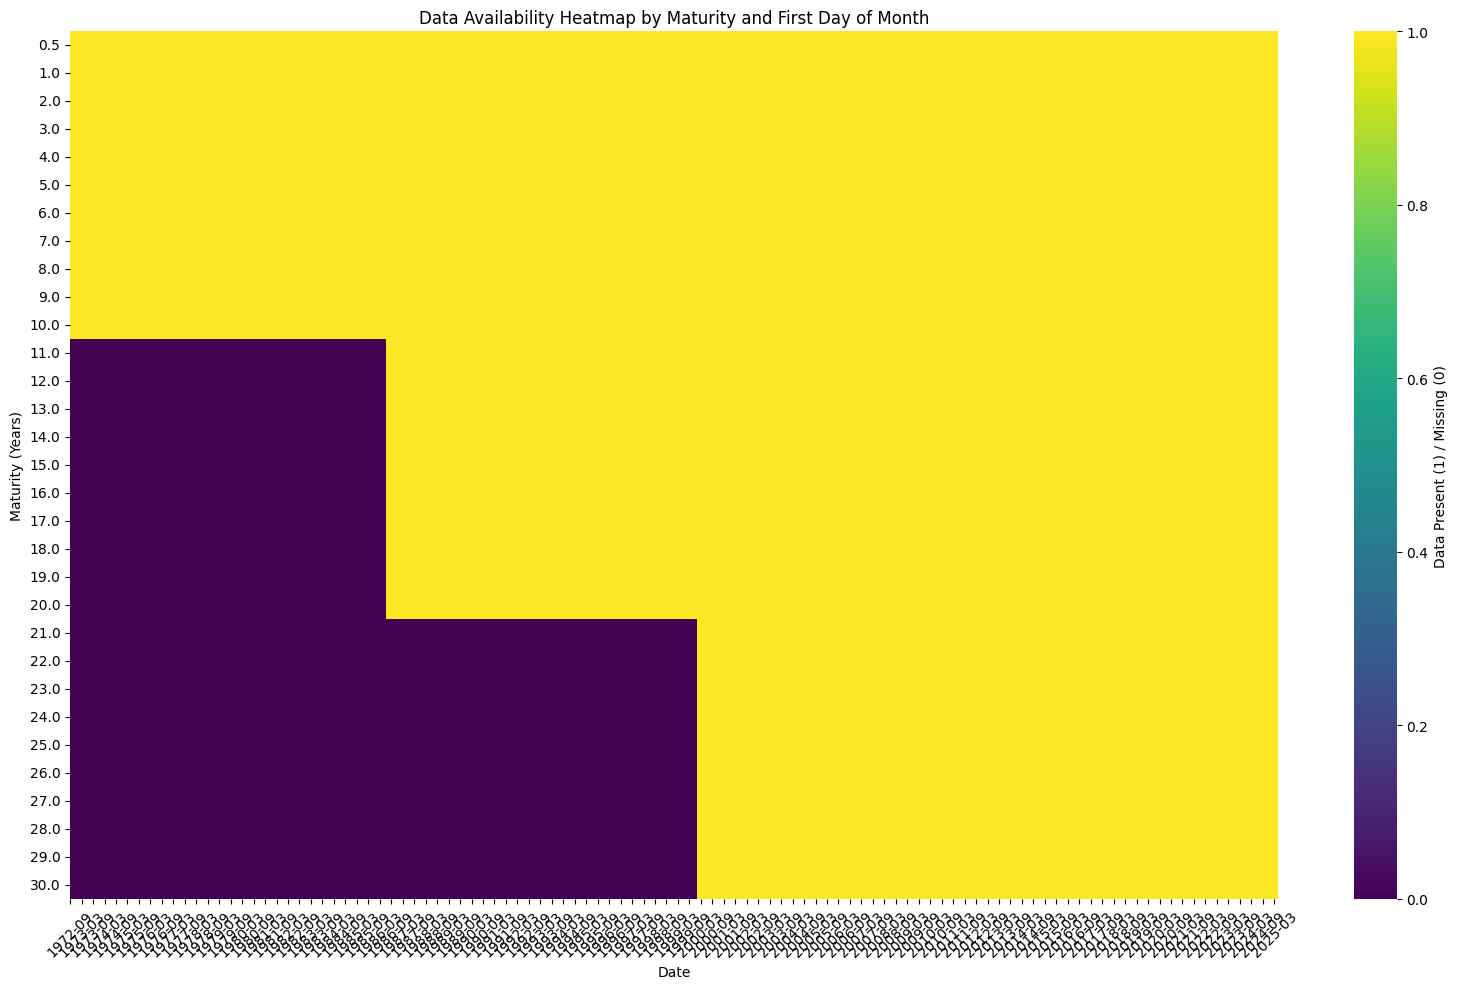

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------- Data Availability Heatmap by Maturity and Calendar Month ---------------- #

# Step 1: Get full range of first-of-month calendar dates
start_date = min(df['Date'].min() for df in dataframes)
end_date = max(df['Date'].max() for df in dataframes)
first_of_months = pd.date_range(start=start_date, end=end_date, freq='MS')  # MS = Month Start (1st of each month)

# Step 2: Initialize heatmap matrix
heatmap_df = pd.DataFrame(index=first_of_months)

# Step 3: Fill in availability per maturity
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[['Date', 'Interest Rate']].copy()
    temp['HasData'] = temp['Interest Rate'].notna().astype(int)
    temp.set_index('Date', inplace=True)
    temp = temp.reindex(first_of_months, fill_value=0)  # Align to 1st of each month
    heatmap_df[maturity] = temp['HasData']

# Step 4: Format and transpose
heatmap_df = heatmap_df.T.sort_index()

# Step 5: X-axis labels (e.g., every 6 months)
xtick_positions = range(0, len(heatmap_df.columns), 6)
xtick_labels = [heatmap_df.columns[i].strftime('%Y-%m') for i in xtick_positions]

# Step 6: Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_df, cmap='viridis', cbar_kws={'label': 'Data Present (1) / Missing (0)'})
plt.title('Data Availability Heatmap by Maturity and First Day of Month')
plt.xlabel('Date')
plt.ylabel('Maturity (Years)')
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.tight_layout()
plt.show()


We can see from the above that for maturities 20-21 until 30 the years 1997-1999 are not present. This will not be analysed now,however will also not be removed as this may represent valuable information for the modeling.

### **<font color='#474747'>*1.2.3 - Data Quality Checks*</font>**

In [ ]:
print("----------------------------------------- DATA QUALITY CHECKS - per File  ---------------------------------------")

quality_checks = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    maturity = df["Maturity"].iloc[0]  # Use the actual numeric Maturity column directly

    # Basic checks
    is_sorted = df["Date"].is_monotonic_increasing
    duplicate_rows = df.duplicated().sum()
    duplicate_dates = df["Date"].duplicated().sum()
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()

    # Negative or zero interest rate values
    ir_col = "Interest Rate"
    if ir_col in df.columns:
        negative_or_zero = (df[ir_col] <= 0).sum()
    else:
        negative_or_zero = None

    quality_checks.append({
        "Maturity": maturity,
        "File Name": file_name,
        "Dates Sorted?": is_sorted,
        "Duplicate Rows": duplicate_rows,
        "Duplicate Dates": duplicate_dates,
        "Missing in 'Date'": missing_counts.get("Date", 0),
        "Missing in 'Interest Rate'": missing_counts.get("Interest Rate", 0),
        "Negative/Zero Interest Rates": negative_or_zero
    })

# Create DataFrame
quality_df = pd.DataFrame(quality_checks)
quality_df.set_index("Maturity", inplace=True)
quality_df = quality_df.sort_index()

# Display summary
from IPython.display import display
display(quality_df)

print("\n**Data Quality Check Complete!**\n")


----------------------------------------- DATA QUALITY CHECKS - per File  ---------------------------------------


File Name  Dates Sorted?  \
Maturity                                                                     
0.5       monthly-term-structure-spot-interest-rate-R005...           True   
1.0       monthly-term-structure-spot-interest-rate-R01X...           True   
2.0       monthly-term-structure-spot-interest-rate-R02X...           True   
3.0       monthly-term-structure-spot-interest-rate-R03X...           True   
4.0       monthly-term-structure-spot-interest-rate-R04X...           True   
5.0       monthly-term-structure-spot-interest-rate-R05X...           True   
6.0       monthly-term-structure-spot-interest-rate-R06X...           True   
7.0       monthly-term-structure-spot-interest-rate-R07X...           True   
8.0       monthly-term-structure-spot-interest-rate-R08X...           True   
9.0       monthly-term-structure-spot-interest-rate-R09X...           True   
10.0      monthly-term-structure-spot-interest-rate-R10X...           True   
11.0      monthly-term-structure-spot-interest-rate-R11X...           True   
12.0      monthly-term-structure-spot-interest-rate-R12X...           True   
13.0      monthly-term-structure-spot-interest-rate-R13X...           True   
14.0      monthly-term-structure-spot-interest-rate-R14X...           True   
15.0      monthly-term-structure-spot-interest-rate-R15X...           True   
16.0      monthly-term-structure-spot-interest-rate-R16X...           True   
17.0      monthly-term-structure-spot-interest-rate-R17X...           True   
18.0      monthly-term-structure-spot-interest-rate-R18X...           True   
19.0      monthly-term-structure-spot-interest-rate-R19X...           True   
20.0      monthly-term-structure-spot-interest-rate-R20X...           True   
21.0      monthly-term-structure-spot-interest-rate-R21X...           True   
22.0      monthly-term-structure-spot-interest-rate-R22X...           True   
23.0      monthly-term-structure-spot-interest-rate-R23X...           True   
24.0      monthly-term-structure-spot-interest-rate-R24X...           True   
25.0      monthly-term-structure-spot-interest-rate-R25X...           True   
26.0      monthly-term-structure-spot-interest-rate-R26X...           True   
27.0      monthly-term-structure-spot-interest-rate-R27X...           True   
28.0      monthly-term-structure-spot-interest-rate-R28X...           True   
29.0      monthly-term-structure-spot-interest-rate-R29X...           True   
30.0      monthly-term-structure-spot-interest-rate-R30X...           True   

          Duplicate Rows  Duplicate Dates  Missing in 'Date'  \
Maturity                                                       
0.5                    0                0                  0   
1.0                    0                0                  0   
2.0                    0                0                  0   
3.0                    0                0                  0   
4.0                    0                0                  0   
5.0                    0                0                  0   
6.0                    0                0                  0   
7.0                    0                0                  0   
8.0                    0                0                  0   
9.0                    0                0                  0   
10.0                   0                0                  0   
11.0                   0                0                  0   
12.0                   0                0                  0   
13.0                   0                0                  0   
14.0                   0                0                  0   
15.0                   0                0                  0   
16.0                   0                0                  0   
17.0                   0                0                  0   
18.0                   0                0                  0   
19.0                   0                0                  0   
20.0                   0                0                  0   
21.


**Data Quality Check Complete!**



### **<font color='#474747'>*1.2.4 - Missing Values Per XXX*</font>**


##### **1.2.4.1 - Missing Values - Per Month**
* Count
* Percentage

In [ ]:
#------------------------------   MISSING VALUES - Per Month ---------------#

# Storage for results
monthly_counts = []
monthly_percentages = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Ensure valid dates
    df = df[df["Date"].notnull()].copy()
    df["Month"] = df["Date"].dt.strftime("%B")

    # Count total and missing interest rates per month
    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    # Ensure consistent month order
    months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    for month in months:
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        row_counts[month] = missing
        row_percentages[month] = round((missing / total * 100), 2) if total > 0 else None

    monthly_counts.append(row_counts)
    monthly_percentages.append(row_percentages)

# Create DataFrames
missing_month_counts_df = pd.DataFrame(monthly_counts).set_index("Maturity").sort_index()
missing_month_percent_df = pd.DataFrame(monthly_percentages).set_index("Maturity").sort_index()

# Display results
print("Missing Interest Rate Counts by Month:")
display(missing_month_counts_df)

print("Percentage Missing Interest Rates by Month:")
display(missing_month_percent_df)


Missing Interest Rate Counts by Month:


January  February  March  April  May  June  July  August  September  \
Maturity                                                                        
0.5             0         0      0      0    0     0     0       0          0   
1.0             0         0      0      0    0     0     0       0          0   
2.0             0         0      0      0    0     0     0       0          0   
3.0             0         0      0      0    0     0     0       0          0   
4.0             0         0      0      0    0     0     0       0          0   
5.0             0         0      0      0    0     0     0       0          0   
6.0             0         0      0      0    0     0     0       0          0   
7.0             0         0      0      0    0     0     0       0          0   
8.0             0         0      0      0    0     0     0       0          0   
9.0             0         0      0      0    0     0     0       0          0   
10.0            0         0      0      0    0     0     0       0          0   
11.0            0         0      0      0    0     0     0       0          0   
12.0            0         0      0      0    0     0     0       0          0   
13.0            0         0      0      0    0     0     0       0          0   
14.0            0         0      0      0    0     0     0       0          0   
15.0            0         0      0      0    0     0     0       0          0   
16.0            0         0      0      0    0     0     0       0          0   
17.0            0         0      0      0    0     0     0       0          0   
18.0            0         0      0      0    0     0     0       0          0   
19.0            0         0      0      0    0     0     0       0          0   
20.0            0         0      0      0    0     0     0       0          0   
21.0            0         0      0      0    0     0     0       0          0   
22.0            0         0      0      0    0     0     0       0          0   
23.0            0         0      0      0    0     0     0       0          0   
24.0            0         0      0      0    0     0     0       0          0   
25.0            0         0      0      0    0     0     0       0          0   
26.0            0         0      0      0    0     0     0       0          0   
27.0            0         0      0      0    0     0     0       0          0   
28.0            0         0      0      0    0     0     0       0          0   
29.0            0         0      0      0    0     0     0       0          0   
30.0            0         0      0      0    0     0     0       0          0   

          October  November  December  
Maturity                               
0.5             0         0         0  
1.0             0         0         0  
2.0             0         0         0  
3.0             0         0         0  
4.0             0         0         0  
5.0             0         0         0  
6.0             0         0         0  
7.0             0         0         0  
8.0             0         0         0  
9.0             0         0         0  
10.0            0         0         0  
11.0            0         0         0  
12.0            0         0         0  
13.0            0         0         0  
14.0            0         0         0  
15.0            0         0         0  
16.0            0         0         0  
17.0            0         0         0  
18.0            0         0         0  
19.0            0         0         0  
20.0            0         0         0  
21.0            0         0         0  
22.0            0         0         0  
23.0            0         0         0  
24.0            0         0         0  
25.0            0         0         0  
26.0            0         0         0  
27.0            0         0         0  
28.0            0         0         0  
29.0            0         0         0  
30.0            0         0         0

Percentage Missing Interest Rates by Month:


January  February  March  April  May  June  July  August  September  \
Maturity                                                                        
0.5           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
1.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
2.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
3.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
4.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
5.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
6.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
7.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
8.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
9.0           0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
10.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
11.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
12.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
13.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
14.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
15.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
16.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
17.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
18.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
19.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
20.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
21.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
22.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
23.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
24.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
25.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
26.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
27.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
28.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
29.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   
30.0          0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0        0.0   

          October  November  December  
Maturity                               
0.5           0.0       0.0       0.0  
1.0           0.0       0.0       0.0  
2.0           0.0       0.0       0.0  
3.0           0.0       0.0       0.0  
4.0           0.0       0.0       0.0  
5.0           0.0       0.0       0.0  
6.0           0.0       0.0       0.0  
7.0           0.0       0.0       0.0  
8.0           0.0       0.0       0.0  
9.0           0.0       0.0       0.0  
10.0          0.0       0.0       0.0  
11.0          0.0       0.0       0.0  
12.0          0.0       0.0       0.0  
13.0          0.0       0.0       0.0  
14.0          0.0       0.0       0.0  
15.0          0.0       0.0       0.0  
16.0          0.0       0.0       0.0  
17.0          0.0       0.0       0.0  
18.0          0.0       0.0       0.0  
19.0          0.0       0.0       0.0  
20.0          0.0       0.0       0.0  
21.0          0.0       0.0       0.0  
22.0          0.0       0.0       0.0  
23.0          0.0       0.0       0.0  
24.0          0.0       0.0       0.0  
25.0          0.0       0.0       0.0  
26.0          0.0       0.0       0.0  
27.0          0.0       0.0       0.0  
28.0          0.0       0.0       0.0  
29.0          0.0       0.0       0.0  
30.0          0.0       0.0       0.0

###### **1.2.4.1.a - Heatmap Missing Values**

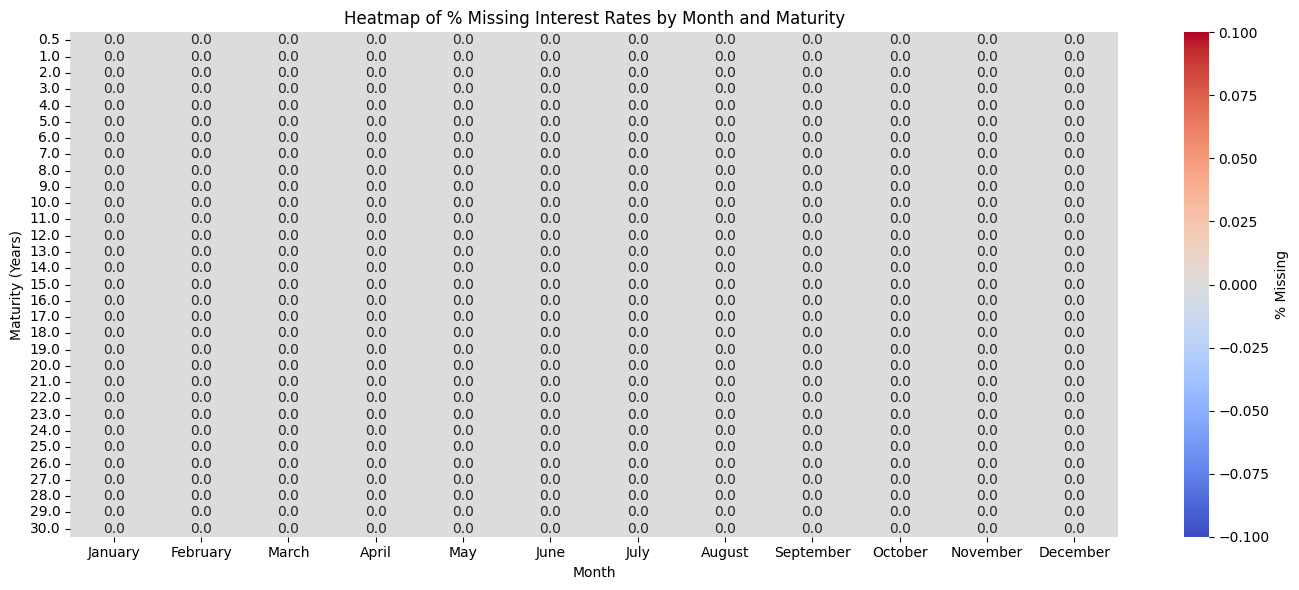

In [ ]:

# Reorder month columns for better readability
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Filter and reorder the columns in the percentage DataFrame
heatmap_data_month = missing_month_percent_df[month_order]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data_month, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Month and Maturity")
plt.xlabel("Month")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### **1.2.4.2 - Missing Values - Per YYYY-MM**
* Count
* Percentage

In [ ]:
#------------------------------   MISSING VALUES - Per YYYY-MM ---------------#
# Storage for results
monthly_counts = []
monthly_percentages = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    df = df[df["Date"].notnull()].copy()
    df["Month"] = df["Date"].dt.to_period("M").astype(str)  # Format as 'YYYY-MM'

    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for month in sorted(total_counts.index):  # Ensure sorted months
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        row_counts[month] = missing
        row_percentages[month] = round((missing / total * 100), 2) if total > 0 else None

    monthly_counts.append(row_counts)
    monthly_percentages.append(row_percentages)

# Create DataFrames
missing_month_counts_df = pd.DataFrame(monthly_counts).set_index("Maturity").sort_index()
missing_month_percent_df = pd.DataFrame(monthly_percentages).set_index("Maturity").sort_index()

# Display results
print("Missing Interest Rate Counts by YYYY-MM:")
display(missing_month_counts_df)

print("Percentage Missing Interest Rates by YYYY-MM:")
display(missing_month_percent_df)


Missing Interest Rate Counts by YYYY-MM:


1972-09  1972-10  1972-11  1972-12  1973-01  1973-02  1973-03  \
Maturity                                                                  
0.5           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
5.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
8.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
9.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10.0          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
11.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
12.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
13.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
16.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
17.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
19.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
20.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
21.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   

          1973-04  1973-05  1973-06  ...  2024-07  2024-08  2024-09  2024-10  \
Maturity                             ...                                       
0.5           0.0      0.0      0.0  ...        0        0        0        0   
1.0           0.0      0.0      0.0  ...        0        0        0        0   
2.0           0.0      0.0      0.0  ...        0        0        0        0   
3.0           0.0      0.0      0.0  ...        0        0        0        0   
4.0           0.0      0.0      0.0  ...        0        0        0        0   
5.0           0.0      0.0      0.0  ...        0        0        0        0   
6.0           0.0      0.0      0.0  ...        0        0        0        0   
7.0           0.0      0.0      0.0  ...        0        0        0        0   
8.0           0.0      0.0      0.0  ...        0        0        0        0   
9.0           0.0      0.0      0.0  ...        0        0        0        0   
10.0          0.0      0.0      0.0  ...        0        0        0        0   
11.0          NaN      NaN      NaN  ...        0        0        0        0   
12.0          NaN      NaN      NaN  ...        0        0        0        0   
13.0          NaN      NaN      NaN  ...        0        0        0        0   
14.0          NaN      NaN      NaN  ...        0        0        0        0   
15.0          NaN      NaN      NaN  ...        0        0        0        0   
16.0          NaN      NaN      NaN  ...        0        0        0        0   
17.0          

Percentage Missing Interest Rates by YYYY-MM:


1972-09  1972-10  1972-11  1972-12  1973-01  1973-02  1973-03  \
Maturity                                                                  
0.5           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
5.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
8.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
9.0           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10.0          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
11.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
12.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
13.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
16.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
17.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
19.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
20.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
21.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   

          1973-04  1973-05  1973-06  ...  2024-07  2024-08  2024-09  2024-10  \
Maturity                             ...                                       
0.5           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
1.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
2.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
3.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
4.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
5.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
6.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
7.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
8.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
9.0           0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
10.0          0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
11.0          NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
12.0          NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
13.0          NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
14.0          NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
15.0          NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
16.0          NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
17.0          

###### **1.2.4.2.a - Heatmap Missing Values**

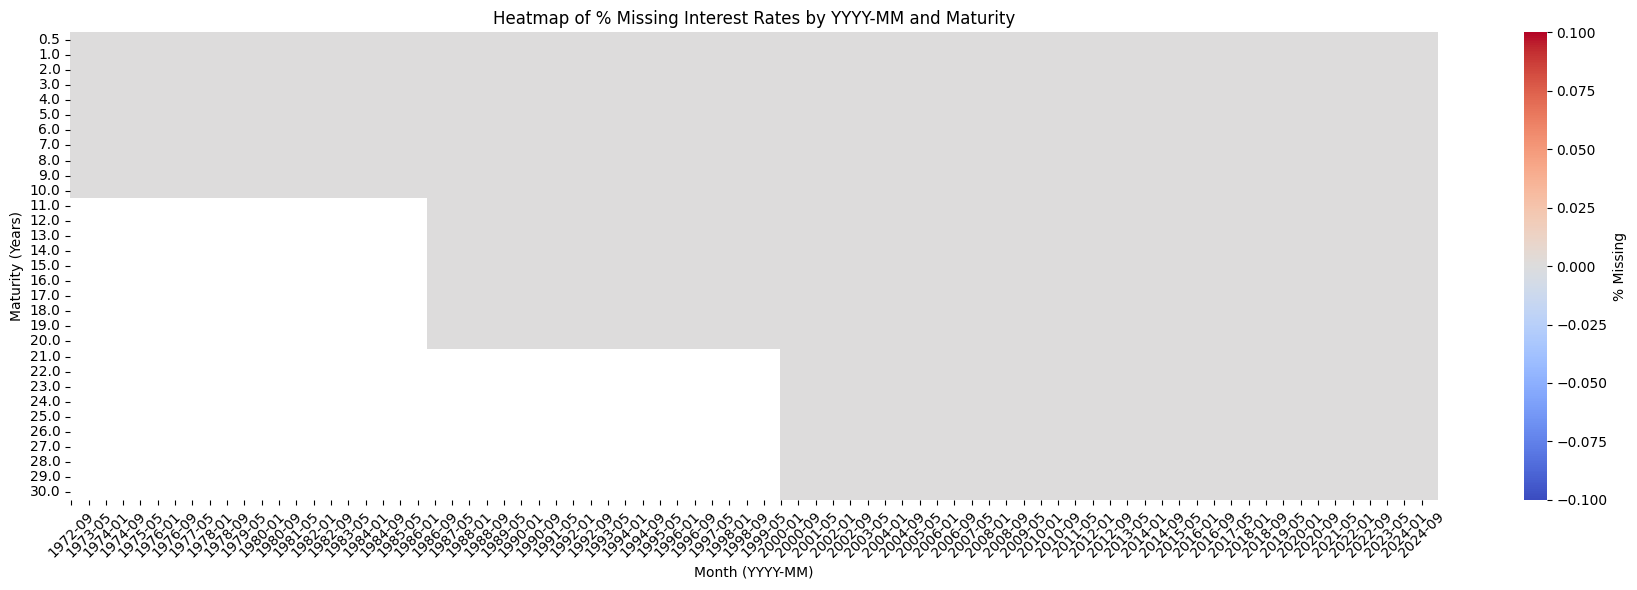

In [ ]:
#------------------------------   HEATMAP OF % MISSING - Per YYYY-MM ---------------#
# Ensure columns are sorted chronologically
heatmap_data_ym = missing_month_percent_df.copy()
heatmap_data_ym = heatmap_data_ym[sorted(heatmap_data_ym.columns)]

# Plot heatmap without annotations
plt.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_data_ym,
    annot=False,  # <-- Remove annotations inside cells
    fmt=".1f",
    cmap="coolwarm",
    cbar_kws={"label": "% Missing"}
)
plt.title("Heatmap of % Missing Interest Rates by YYYY-MM and Maturity")
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Maturity (Years)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


---
---
<br><br>
# **<font color='#000058'>Chapter 2: Data Exploration</font>**


### Next steps:

2. Data exploration: For each DataFrame, explore the data to understand its structure, including the number of rows and columns, data types of each column, descriptive statistics (mean, median, standard deviation, min, max) for numerical columns, and the presence of missing values. Also check for the date range covered in each file.

3. Data analysis: Analyze the relationships between different interest rates within each dataset and across datasets. Calculate correlations between different maturity rates. Look for trends and patterns in interest rate movements over time.

4. Data visualization: Create visualizations to represent the key findings. Visualize the time series of interest rates for different maturities. Show the correlation matrix between interest rates. Visualize any significant trends or patterns.

5. Finish task: Summarize the key characteristics of each dataset, highlighting any commonalities or differences across datasets. Present findings from the data exploration and analysis sections in a clear and concise manner, including the visualizations.

### **<font color='#474747'>*2.1.1 - Summary Statistics*</font>**

In [ ]:
#--------------------- Summary Statistics of Cleaned Interest Rates by Maturity ---------------------#
# Store cleaned data and statistics
cleaned_dataframes = []
statistics = []

for df in dataframes:
    # Use maturity directly from column
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Ensure column names match expected structure
    df_clean = df.dropna(subset=['Interest Rate']).copy()

    # Compute statistics
    stats = {
        'Maturity': maturity,
        'Count': df_clean['Interest Rate'].count(),
        'Mean': df_clean['Interest Rate'].mean(),
        'Median': df_clean['Interest Rate'].median(),
        'Std': df_clean['Interest Rate'].std(),
        'Min': df_clean['Interest Rate'].min(),
        'Max': df_clean['Interest Rate'].max()
    }

    cleaned_dataframes.append(df_clean)
    statistics.append(stats)

# Combine all statistics
stats_df = pd.DataFrame(statistics).sort_values("Maturity").set_index("Maturity")

# Display result
print("#--------------------- Summary Statistics of Cleaned Interest Rates by Maturity ---------------------")
display(stats_df)


#--------------------- Summary Statistics of Cleaned Interest Rates by Maturity ---------------------


Count      Mean  Median       Std   Min   Max
Maturity                                               
0.5        7070  1.518844   1.640  1.834552 -0.98  5.12
1.0        7070  1.562951   1.790  1.843166 -0.97  5.23
2.0        7070  1.659748   1.880  1.865036 -1.02  5.32
3.0        7070  1.780074   1.990  1.886711 -1.02  5.33
4.0        7070  1.913233   2.170  1.901725 -1.00  5.35
5.0        7070  2.049522   2.320  1.909483 -0.98  5.42
6.0        7070  2.182456   2.430  1.911582 -0.95  5.48
7.0        7070  2.308267   2.480  1.910174 -0.93  5.61
8.0        7070  2.424786   2.550  1.907133 -0.91  5.73
9.0        7070  2.531220   2.660  1.903685 -0.88  5.84
10.0       7070  2.627331   2.755  1.900212 -0.85  5.97
11.0       7070  2.713419   2.835  1.897518 -0.82  6.08
12.0       7070  2.790133   2.910  1.895548 -0.80  6.18
13.0       7070  2.857983   2.975  1.894309 -0.77  6.28
14.0       7070  2.917746   3.040  1.893836 -0.74  6.36
15.0       7070  2.970178   3.090  1.894181 -0.72  6.43
16.0       7070  3.015972   3.125  1.894994 -0.69  6.50
17.0       7070  3.055724   3.160  1.896485 -0.67  6.55
18.0       7070  3.090136   3.180  1.898286 -0.65  6.60
19.0       7070  3.119757   3.200  1.900529 -0.64  6.65
20.0       7070  3.145089   3.210  1.903166 -0.62  6.69
21.0       6310  2.872873   2.800  1.800684 -0.61  5.98
22.0       6310  2.888792   2.800  1.801197 -0.60  6.03
23.0       6310  2.901715   2.790  1.801848 -0.58  6.07
24.0       6310  2.911838   2.780  1.802577 -0.57  6.10
25.0       6310  2.919583   2.765  1.803316 -0.56  6.13
26.0       6310  2.925162   2.750  1.804180 -0.55  6.17
27.0       6310  2.928929   2.730  1.805219 -0.54  6.19
28.0       6310  2.931231   2.710  1.806282 -0.52  6.22
29.0       6310  2.932036   2.690  1.807581 -0.51  6.25
30.0       6310  2.931625   2.670  1.808937 -0.50  6.27

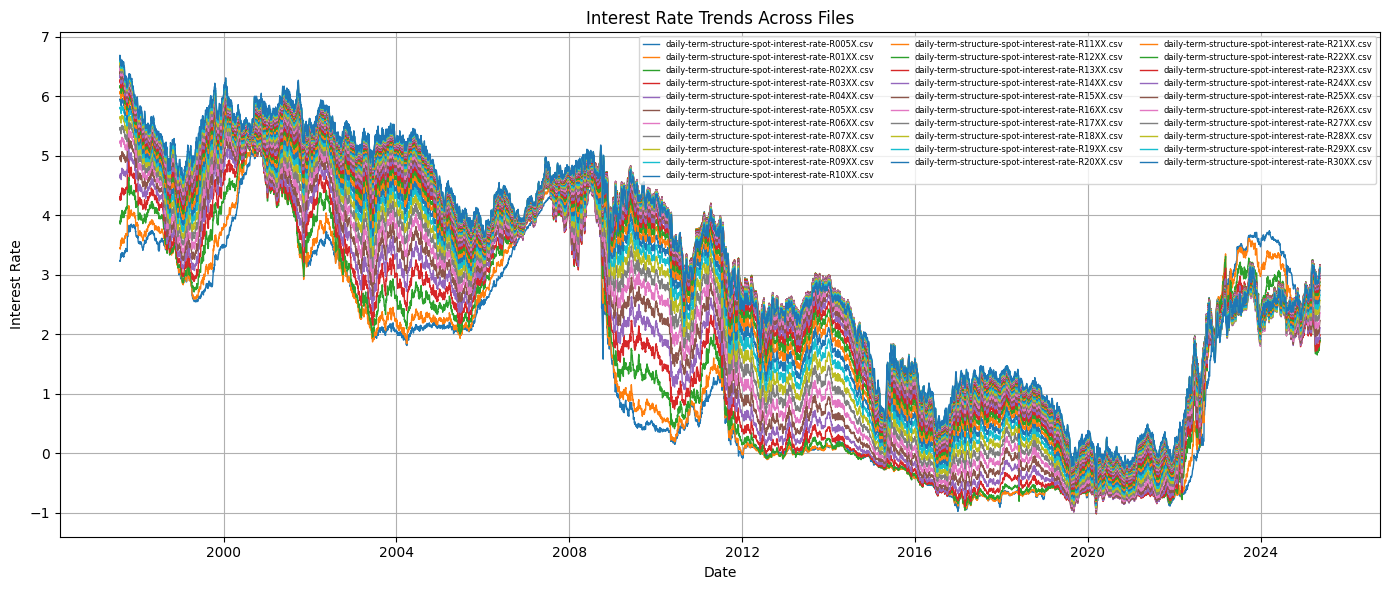

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i, df in enumerate(cleaned_dataframes):
    plt.plot(df['Date'], df['Interest Rate'], label=csv_files[i], linewidth=1)

plt.title('Interest Rate Trends Across Files')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend(loc='upper right', fontsize=6, ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Add index numbers for x-axis
stats_df_sorted = stats_df_sorted.reset_index(drop=True)
plt.figure(figsize=(14, 6))
plt.bar(stats_df_sorted.index, stats_df_sorted['Mean'])

# Label the x-axis with index instead of full filenames
plt.xticks(stats_df_sorted.index, stats_df_sorted.index)
plt.title('Mean Interest Rate per File (File index shown)')
plt.xlabel('File Index (0–30)')
plt.ylabel('Mean Interest Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print index-to-filename map
for i, file in enumerate(stats_df_sorted['File']):
    print(f"{i}: {file}")


NameError: name 'stats_df_sorted' is not defined

In [ ]:
# Combine all into one big DataFrame
combined_df = pd.concat(cleaned_dataframes, ignore_index=True)

# Group by date, calculate mean interest rate across files
daily_avg = combined_df.groupby('Date')['InterestRate'].mean().reset_index()

# Plot the aggregated trend
plt.figure(figsize=(14, 6))
plt.plot(daily_avg['Date'], daily_avg['InterestRate'], label='Average Interest Rate')
plt.title('Average Interest Rate Over Time (All Files Combined)')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'Column not found: InterestRate'

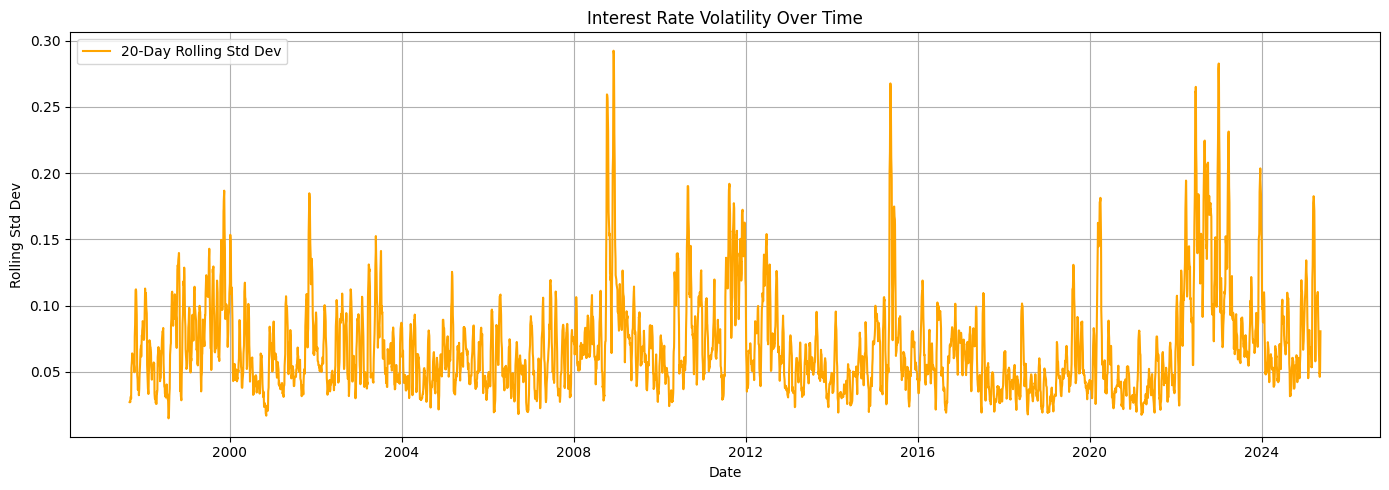

In [ ]:
# 20-day rolling standard deviation
daily_avg['RollingStd'] = daily_avg['InterestRate'].rolling(window=20).std()

plt.figure(figsize=(14, 5))
plt.plot(daily_avg['Date'], daily_avg['RollingStd'], color='orange', label='20-Day Rolling Std Dev')
plt.title('Interest Rate Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Std Dev')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

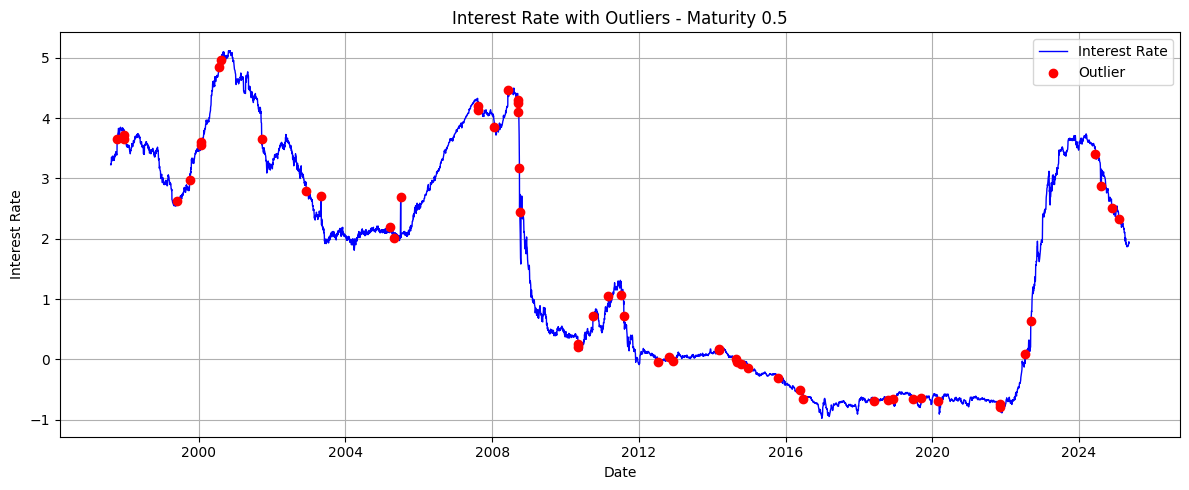

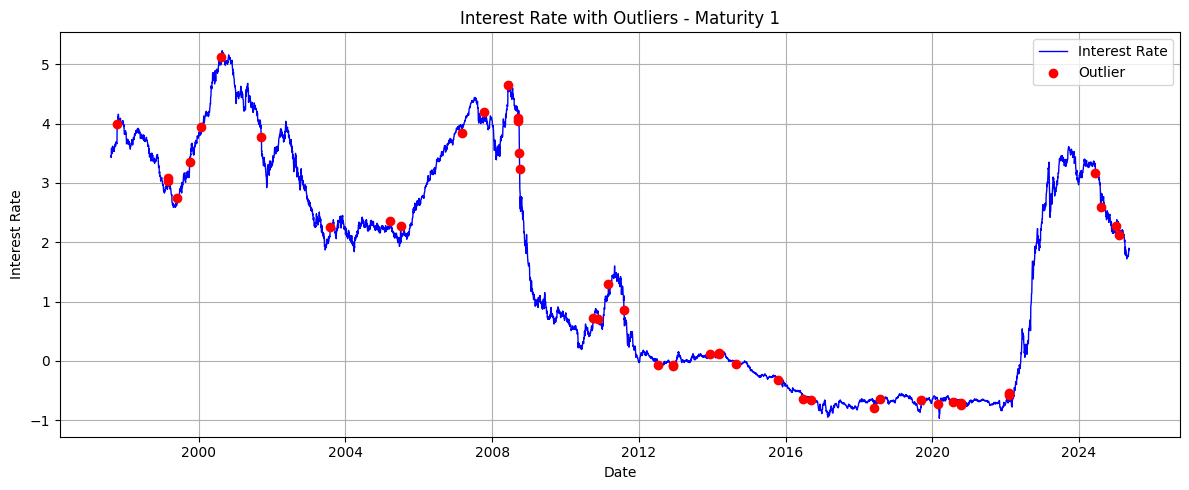

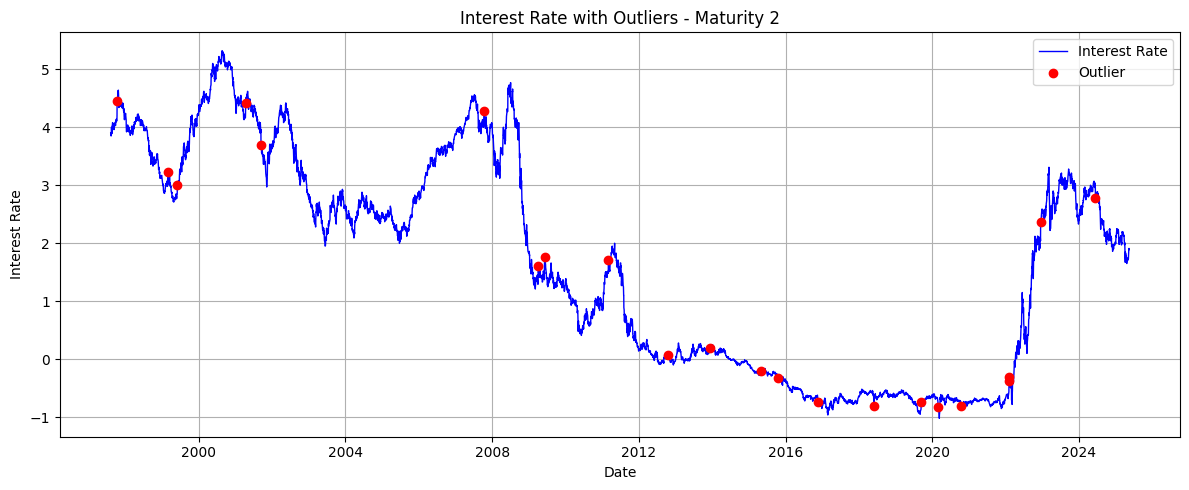

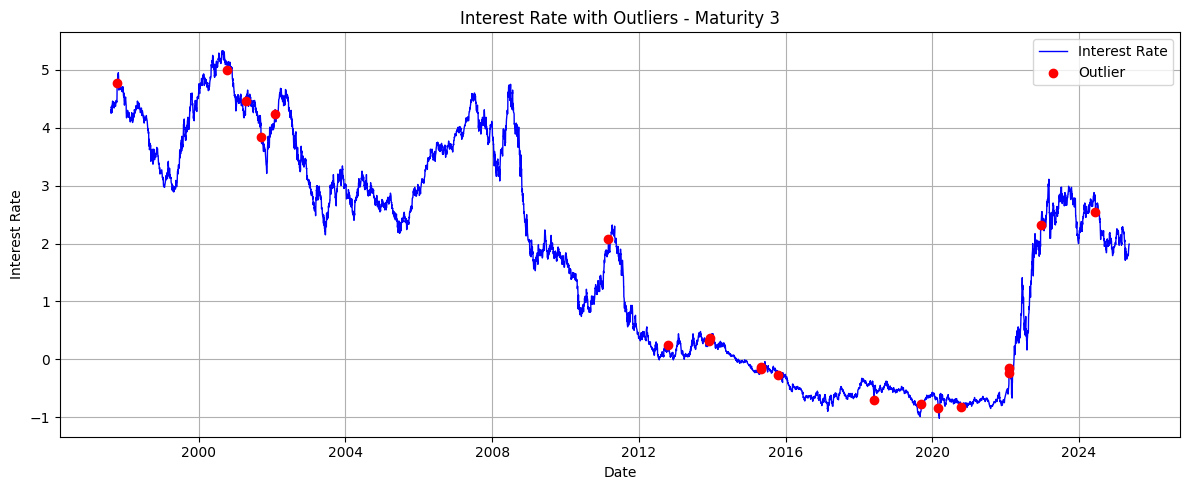

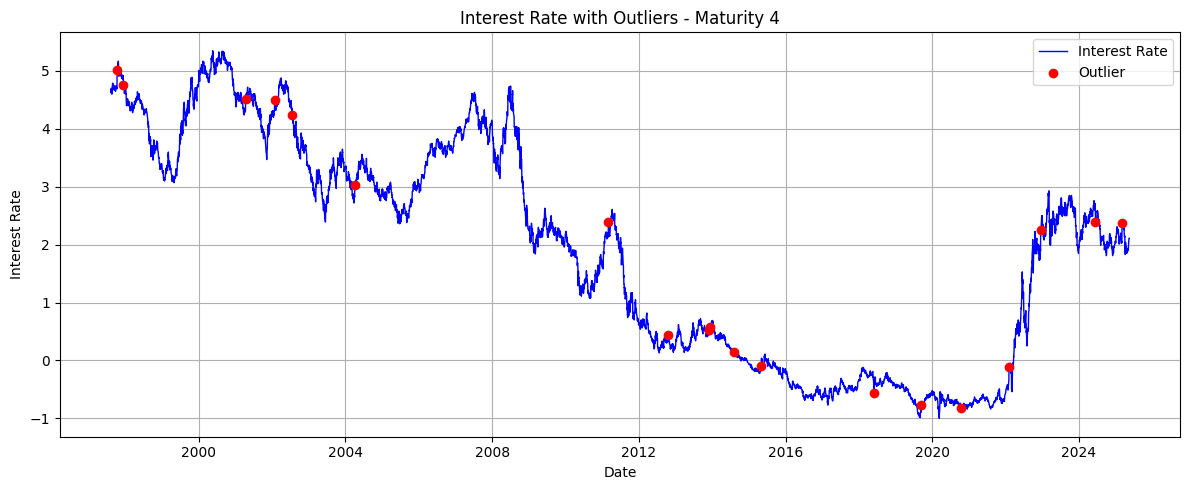

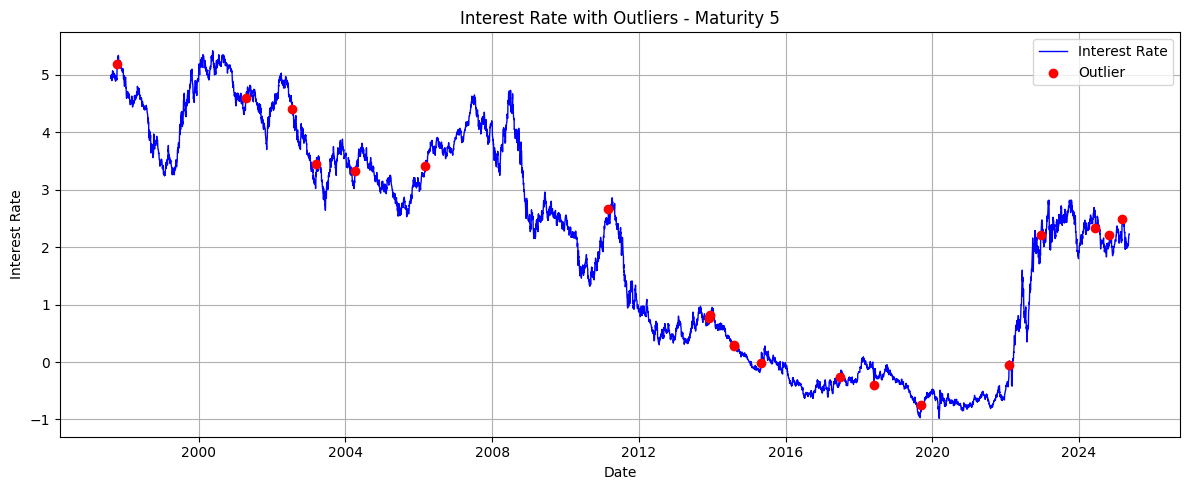

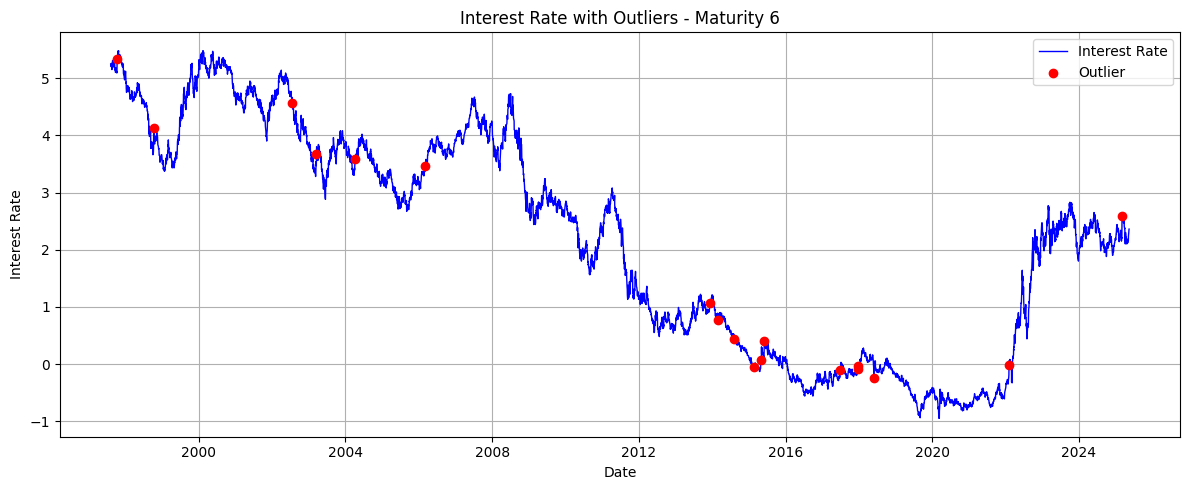

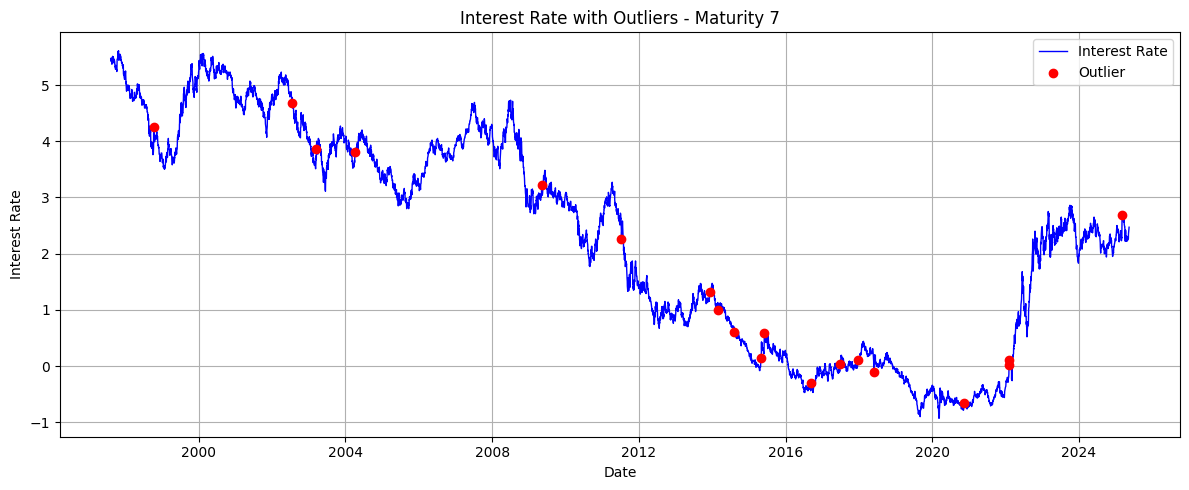

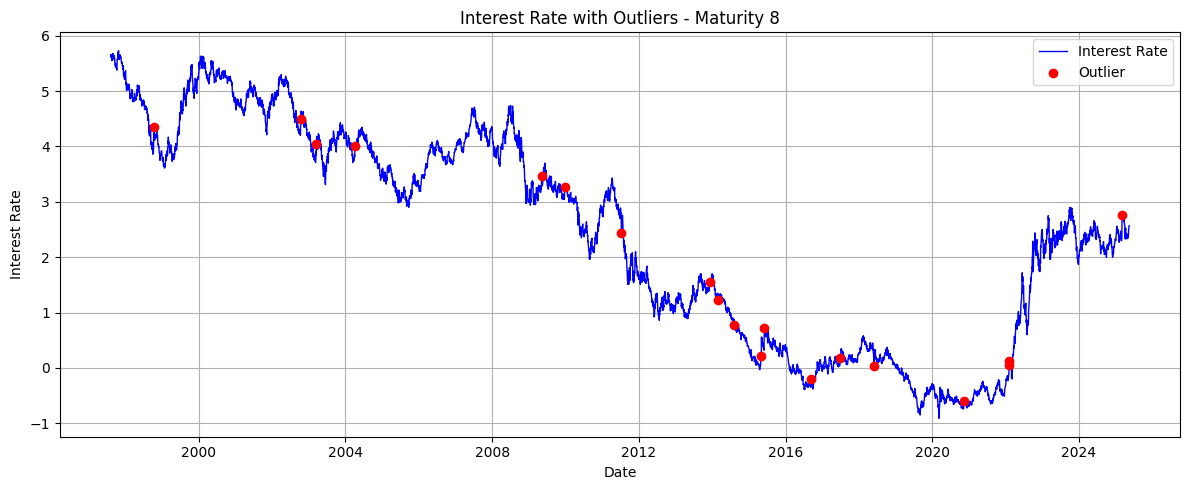

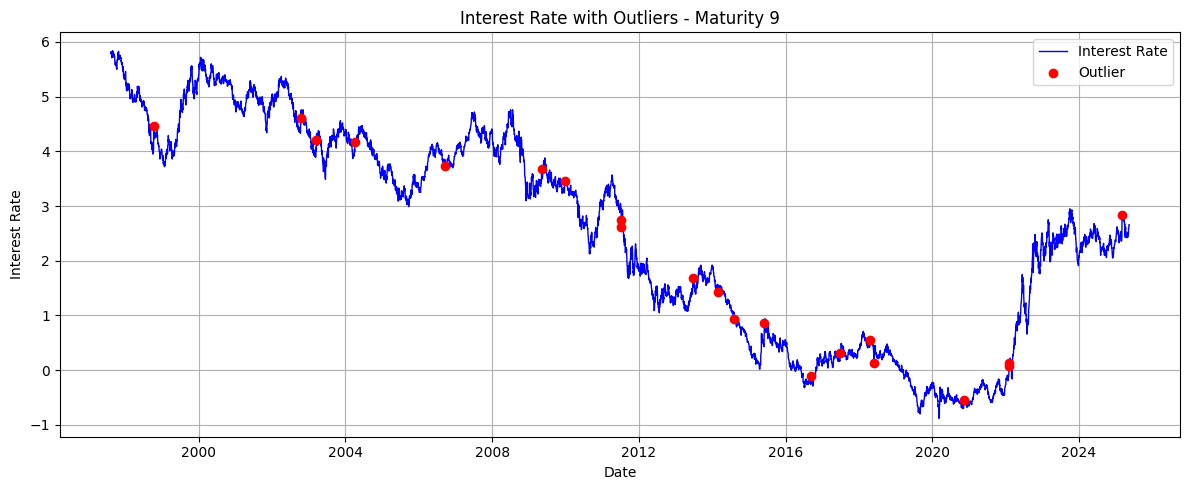

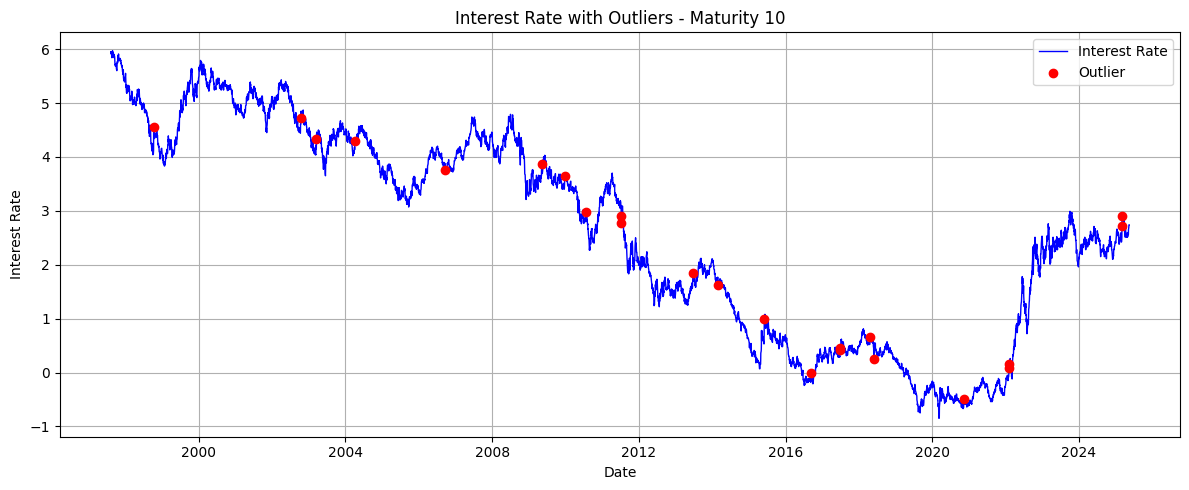

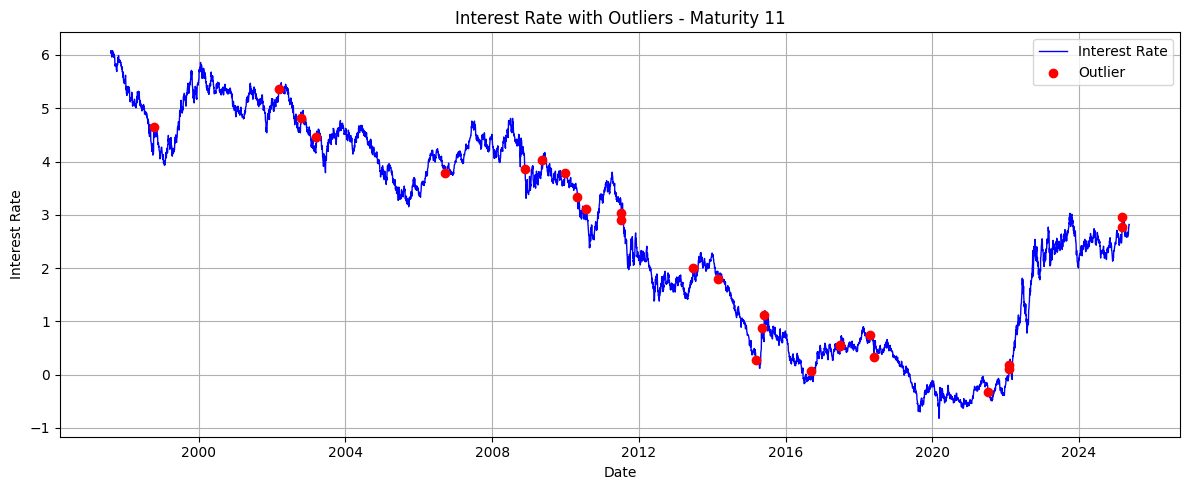

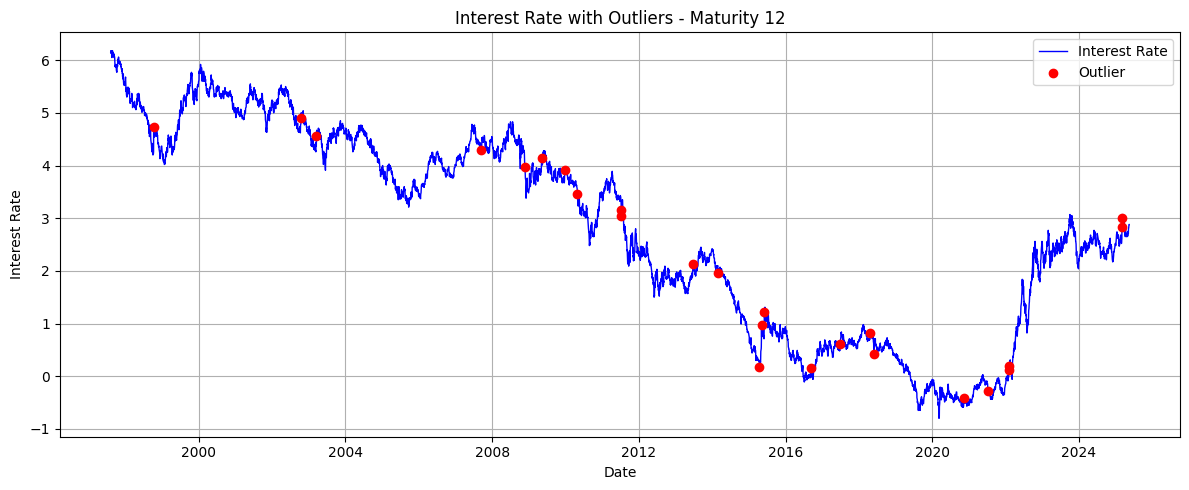

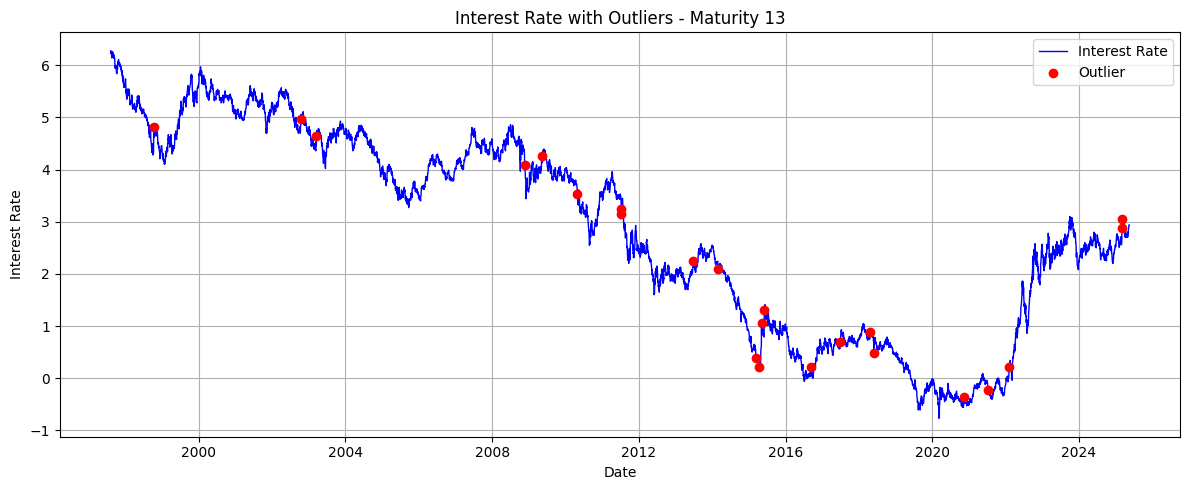

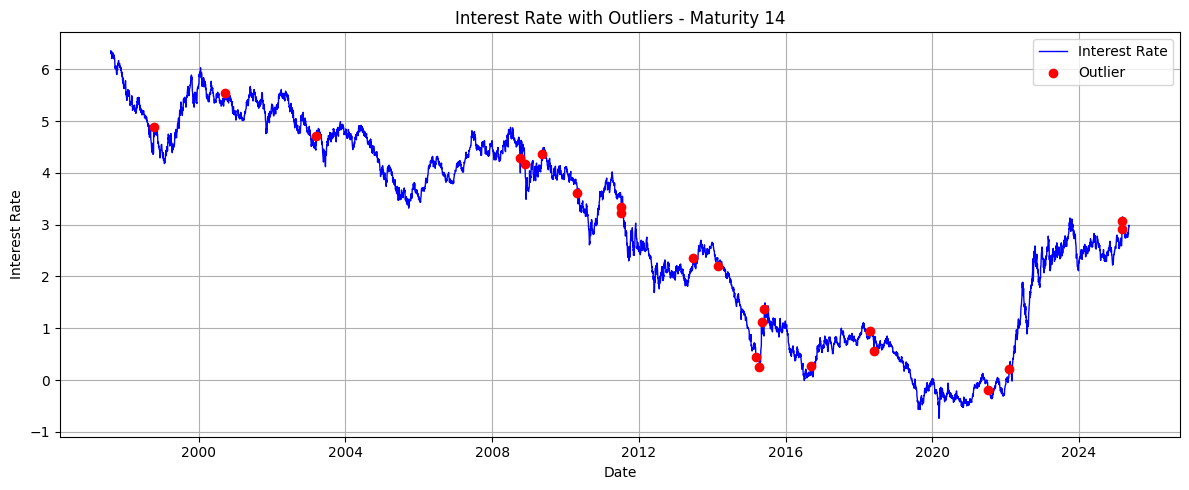

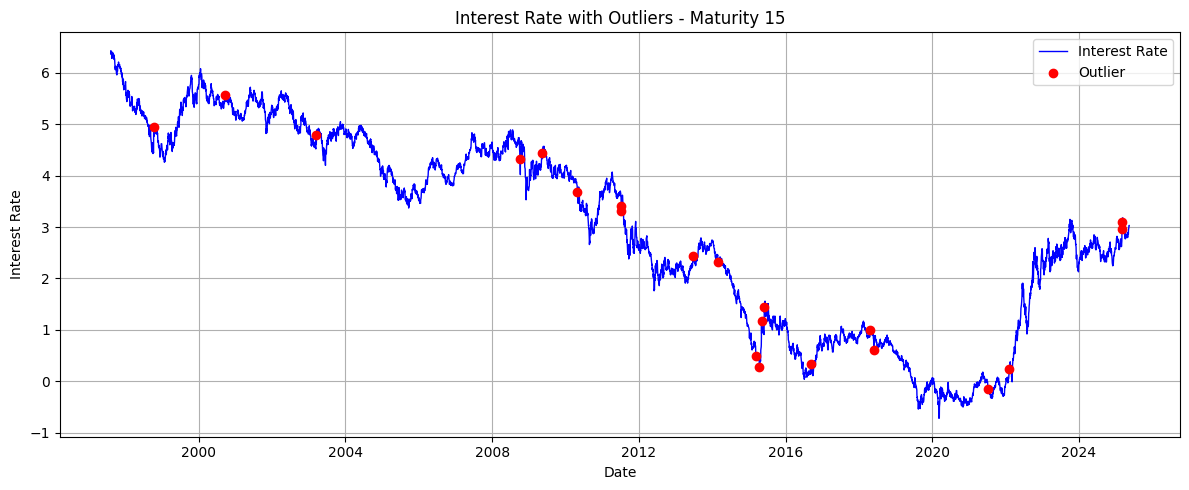

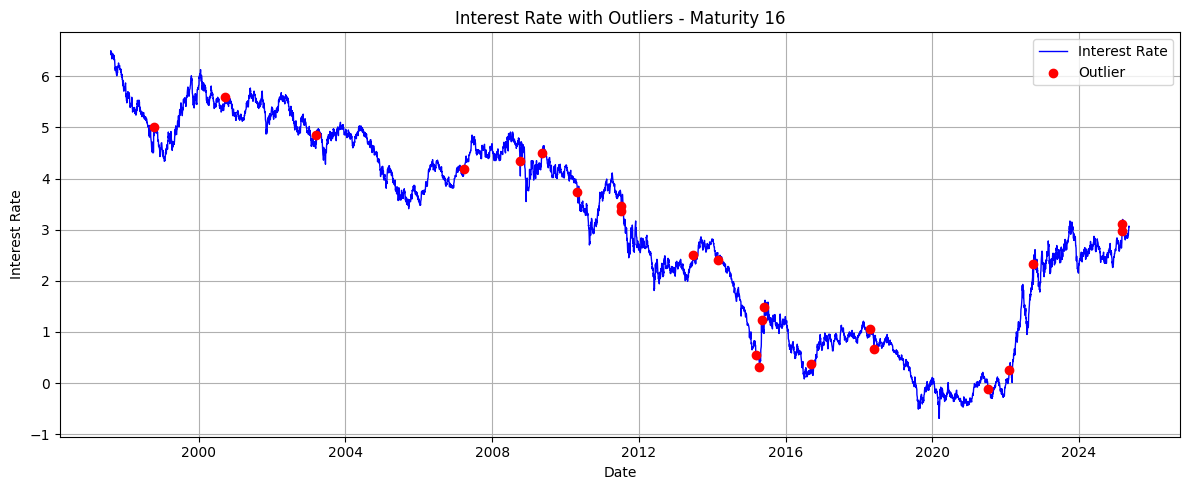

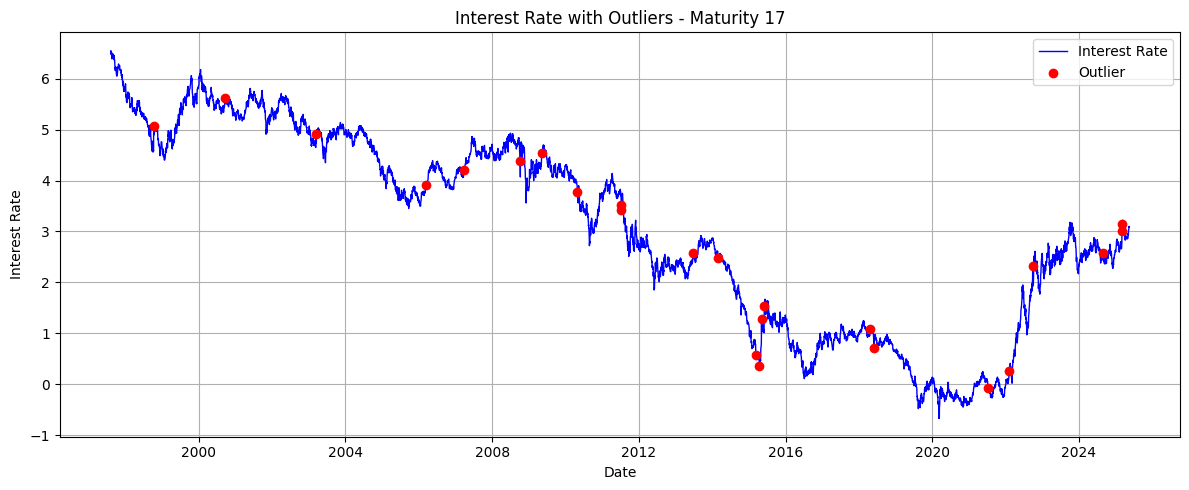

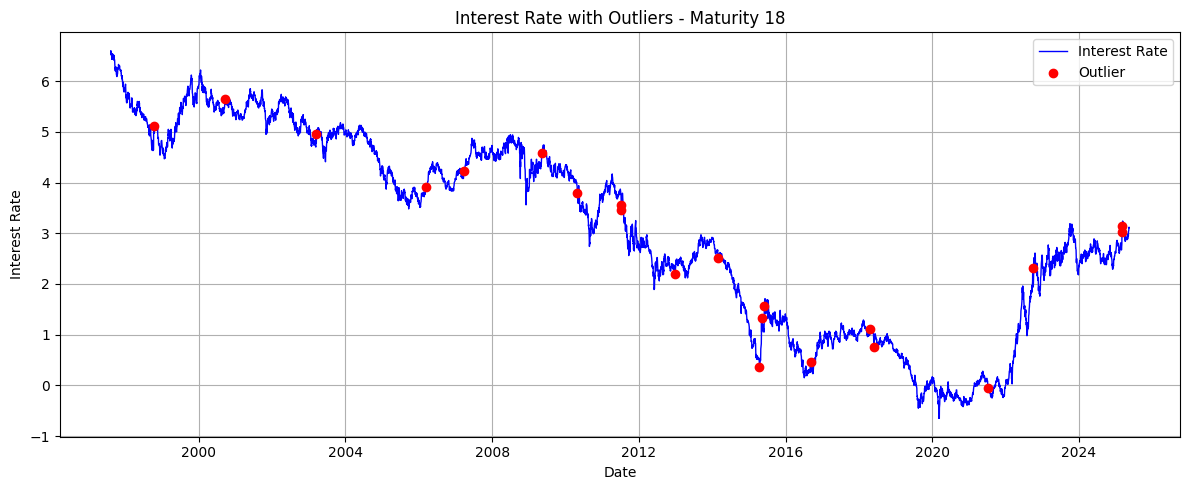

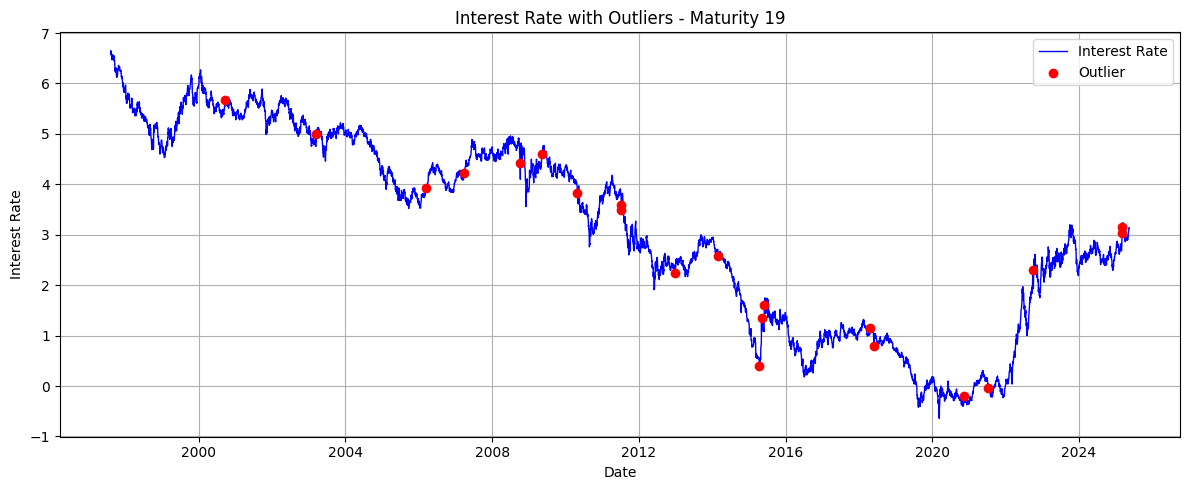

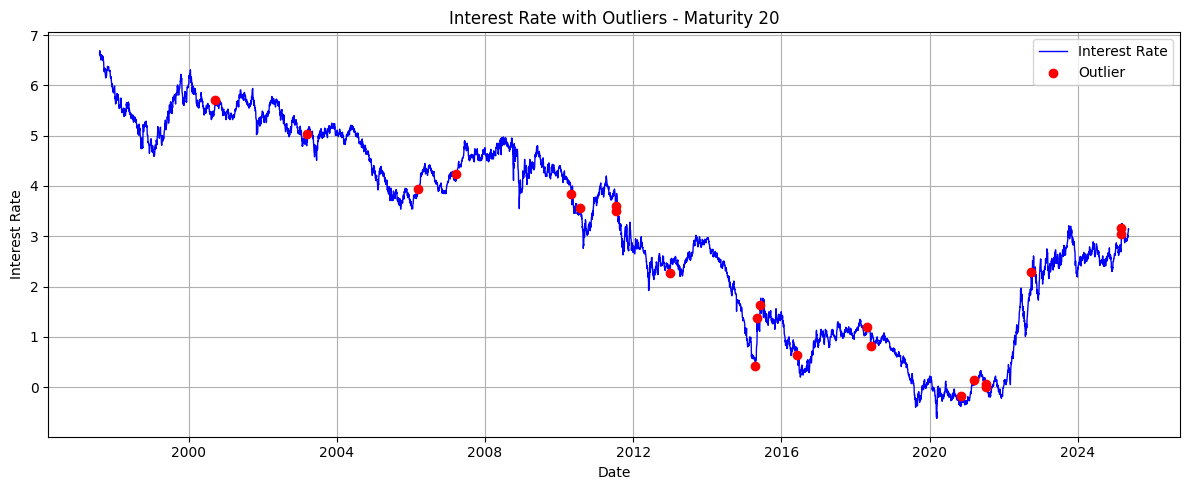

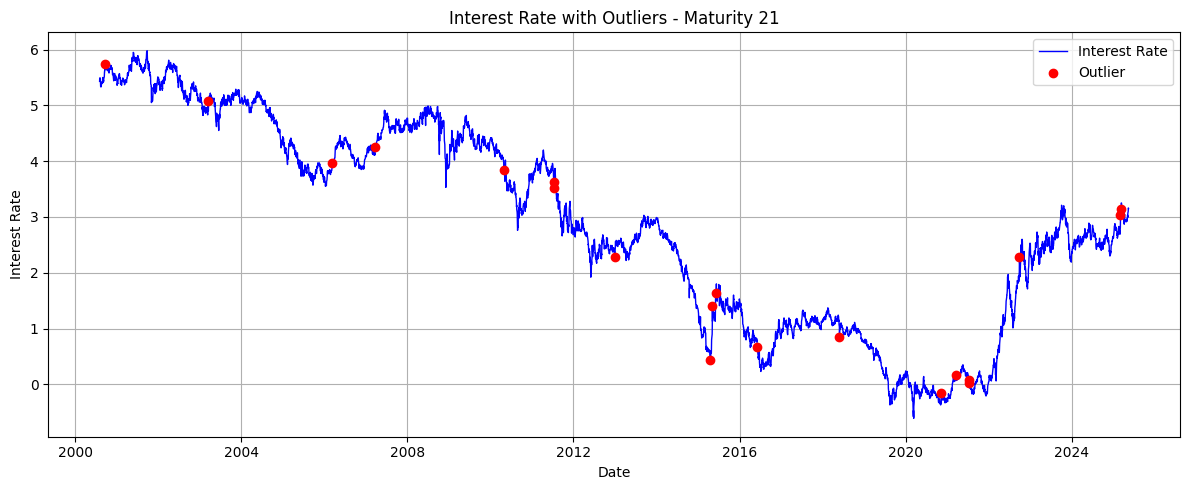

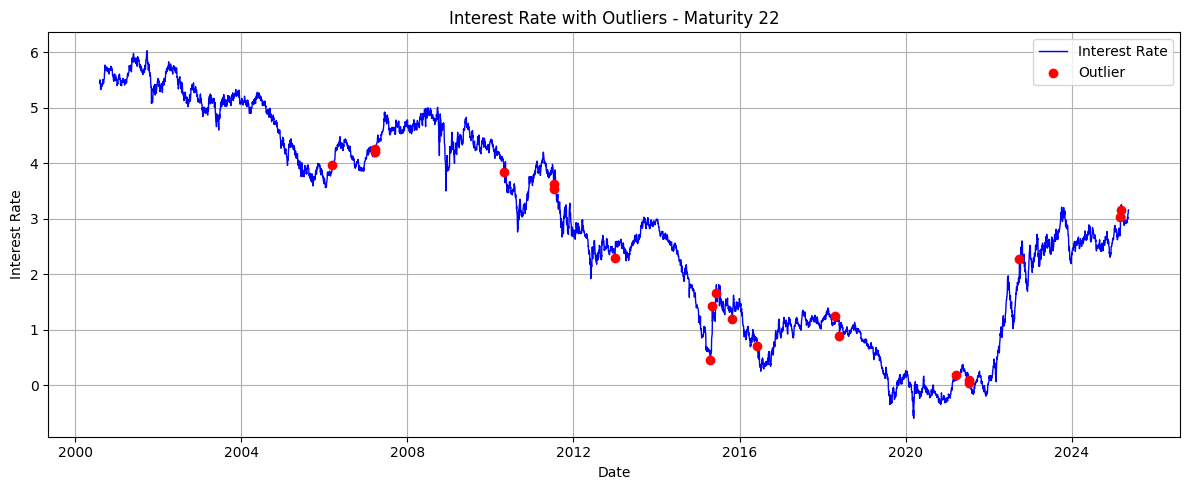

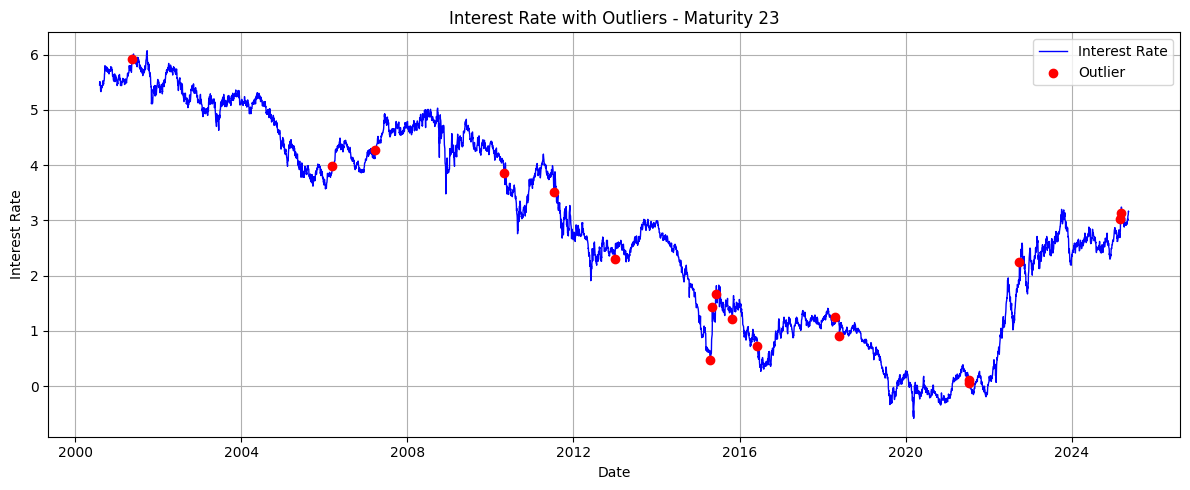

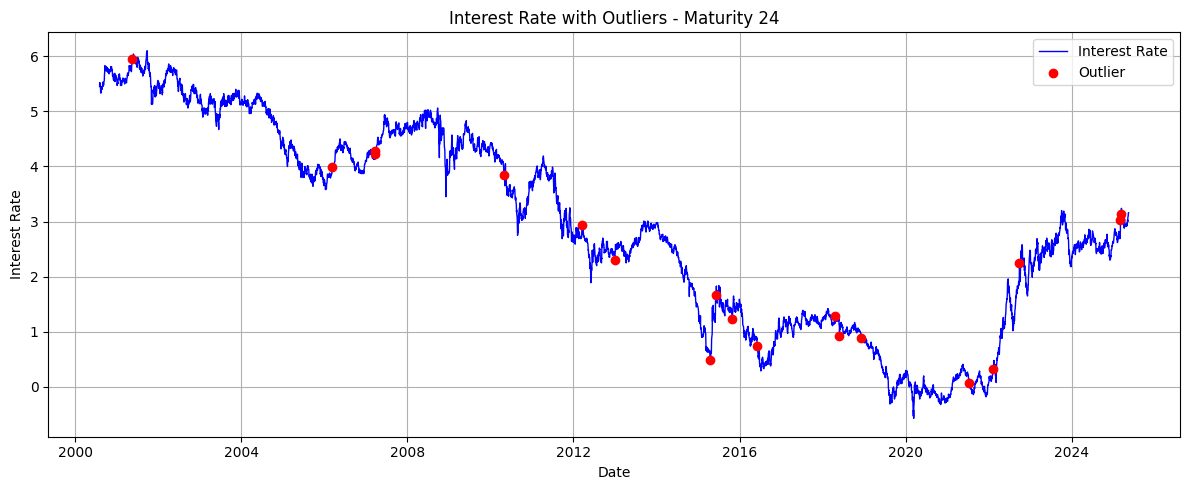

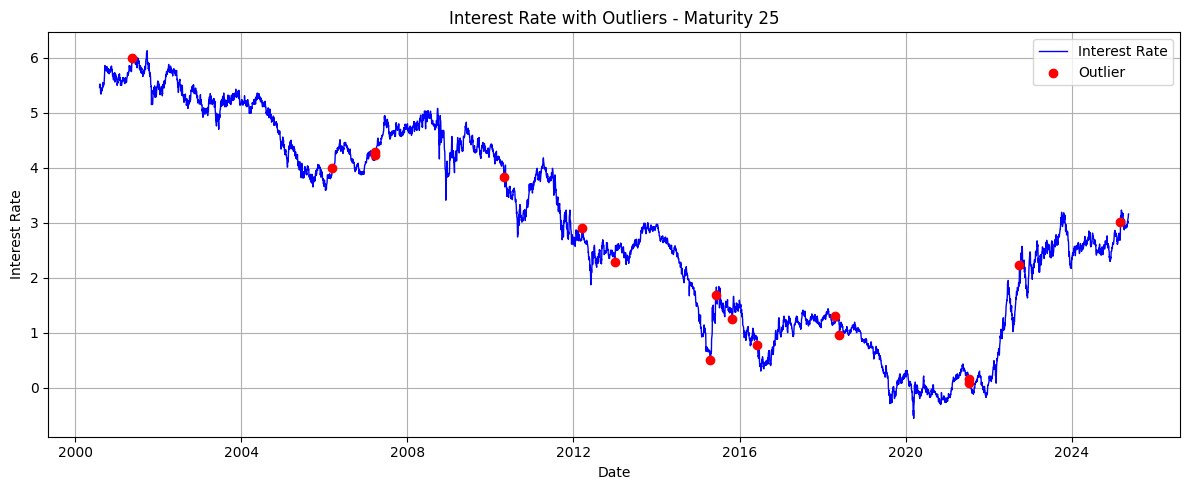

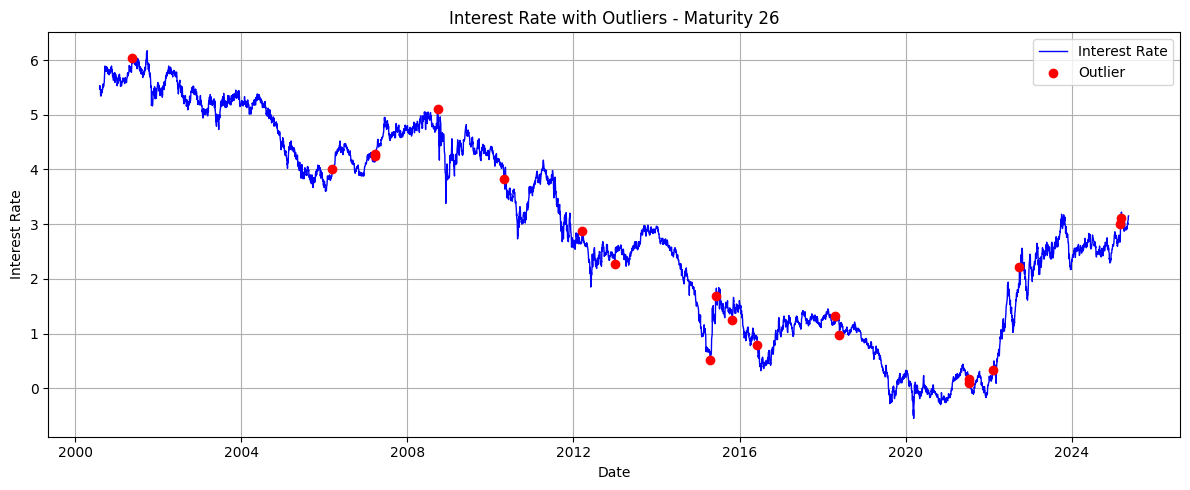

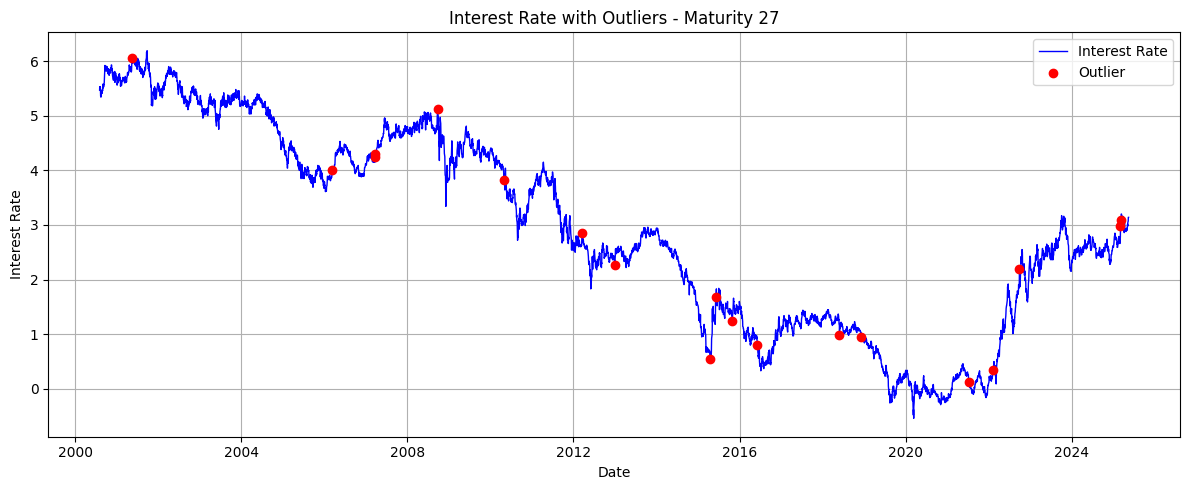

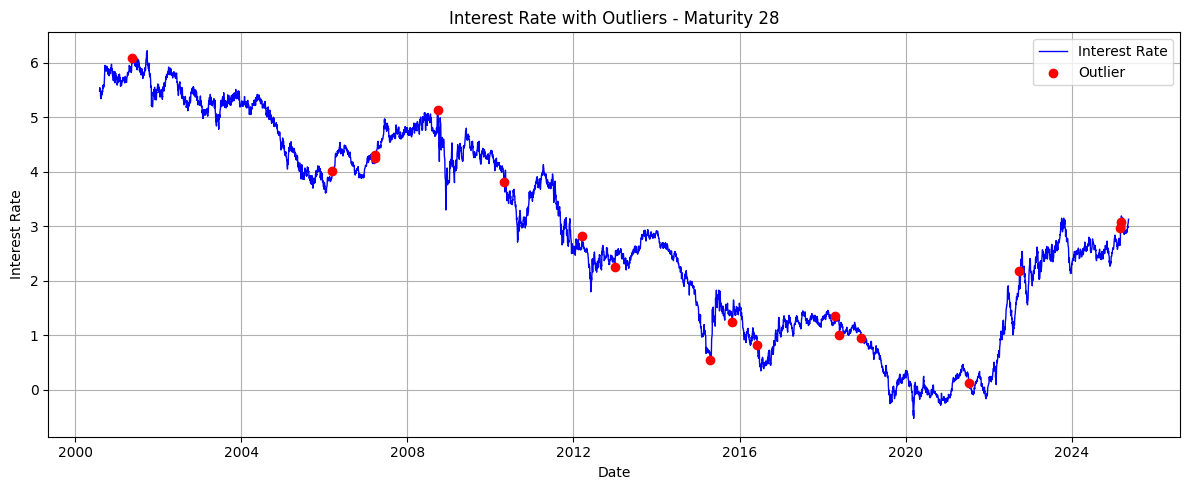

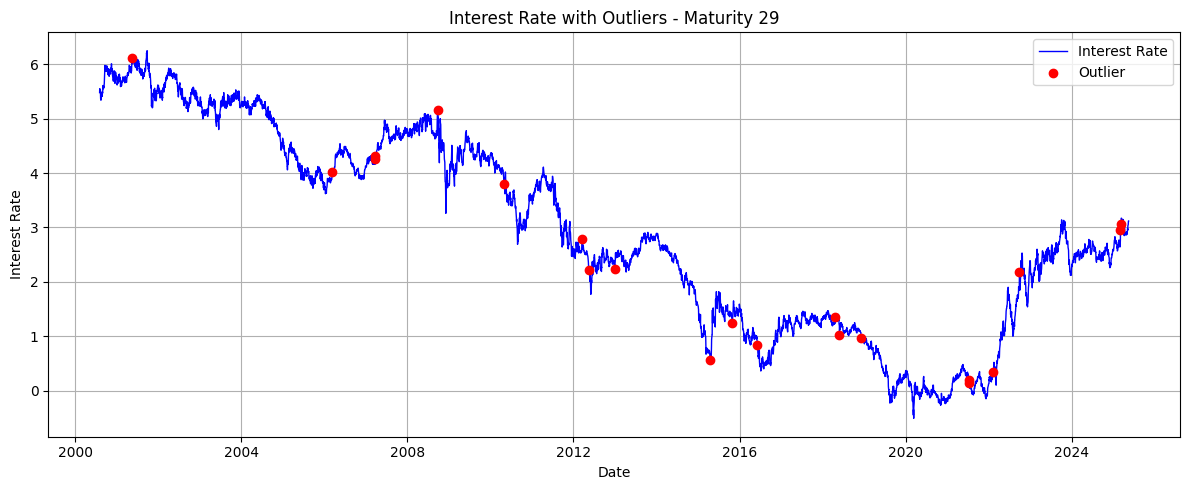

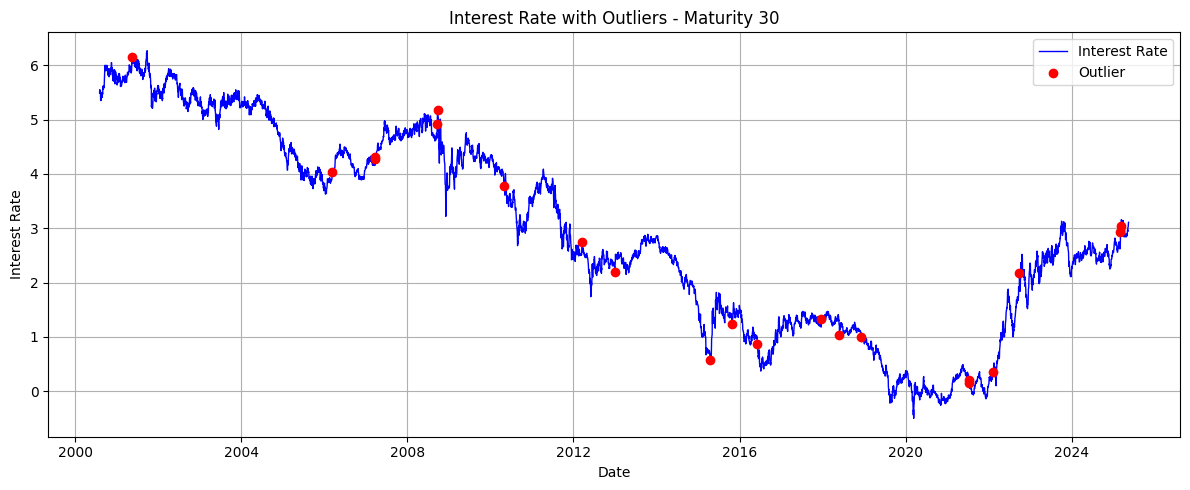

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
window_size = 20
z_threshold = 3

# Loop over all cleaned dataframes
for i, df in enumerate(cleaned_dataframes):
    df = df.copy()
    df.sort_values('Date', inplace=True)

    # Ensure columns are correct
    if 'Interest Rate' not in df.columns:
        continue

    # Rolling mean and standard deviation
    df['RollingMean'] = df['Interest Rate'].rolling(window=window_size, min_periods=10).mean()
    df['RollingStd'] = df['Interest Rate'].rolling(window=window_size, min_periods=10).std()

    # Z-score
    df['ZScore'] = (df['Interest Rate'] - df['RollingMean']) / df['RollingStd']
    df['Outlier'] = df['ZScore'].abs() > z_threshold

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['Interest Rate'], label='Interest Rate', color='blue', linewidth=1)
    plt.scatter(df.loc[df['Outlier'], 'Date'], df.loc[df['Outlier'], 'Interest Rate'],
                color='red', label='Outlier', zorder=5)
    maturity_label = df["Maturity"].iloc[0] if "Maturity" in df.columns else f"Index {i}"
    plt.title(f'Interest Rate with Outliers - Maturity {maturity_label}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
rolling_outlier_summary = []

for i, df in enumerate(cleaned_dataframes):
    df = df.copy()
    df['RollingMean'] = df['InterestRate'].rolling(window=20, min_periods=10).mean()
    df['RollingStd'] = df['InterestRate'].rolling(window=20, min_periods=10).std()
    df['ZScore'] = (df['InterestRate'] - df['RollingMean']) / df['RollingStd']
    df['Outlier'] = df['ZScore'].abs() > 3

    outlier_rows = df[df['Outlier']]

    rolling_outlier_summary.append({
        'File': csv_files[i],
        'Rolling Outlier Count': len(outlier_rows),
        'Max Outlier Value': outlier_rows['InterestRate'].max(),
        'Min Outlier Value': outlier_rows['InterestRate'].min()
    })

rolling_outlier_df = pd.DataFrame(rolling_outlier_summary)
display(rolling_outlier_df)


KeyError: 'InterestRate'

In [ ]:
# Merge all datasets into one by 'Date' column
merged_df = pd.DataFrame()
for i, df in enumerate(cleaned_dataframes):
    temp = df[['Date', 'InterestRate']].copy()
    temp = temp.rename(columns={'InterestRate': csv_files[i]})
    if merged_df.empty:
        merged_df = temp
    else:
        merged_df = pd.merge(merged_df, temp, on='Date', how='outer')


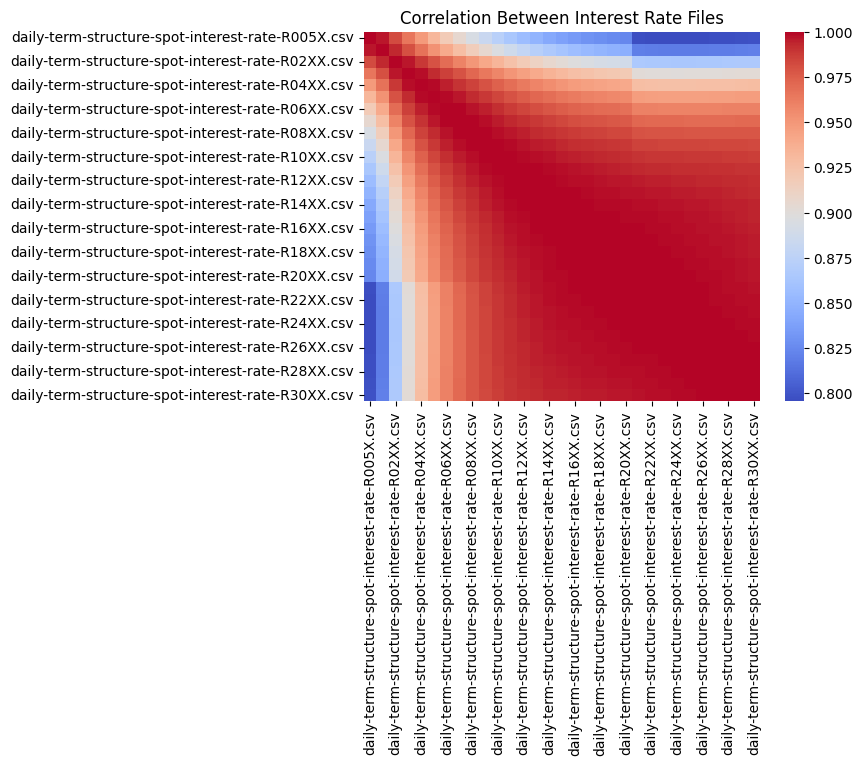

In [ ]:
# Pearson correlation matrix
correlation_matrix = merged_df.drop(columns=['Date']).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Between Interest Rate Files")
plt.show()


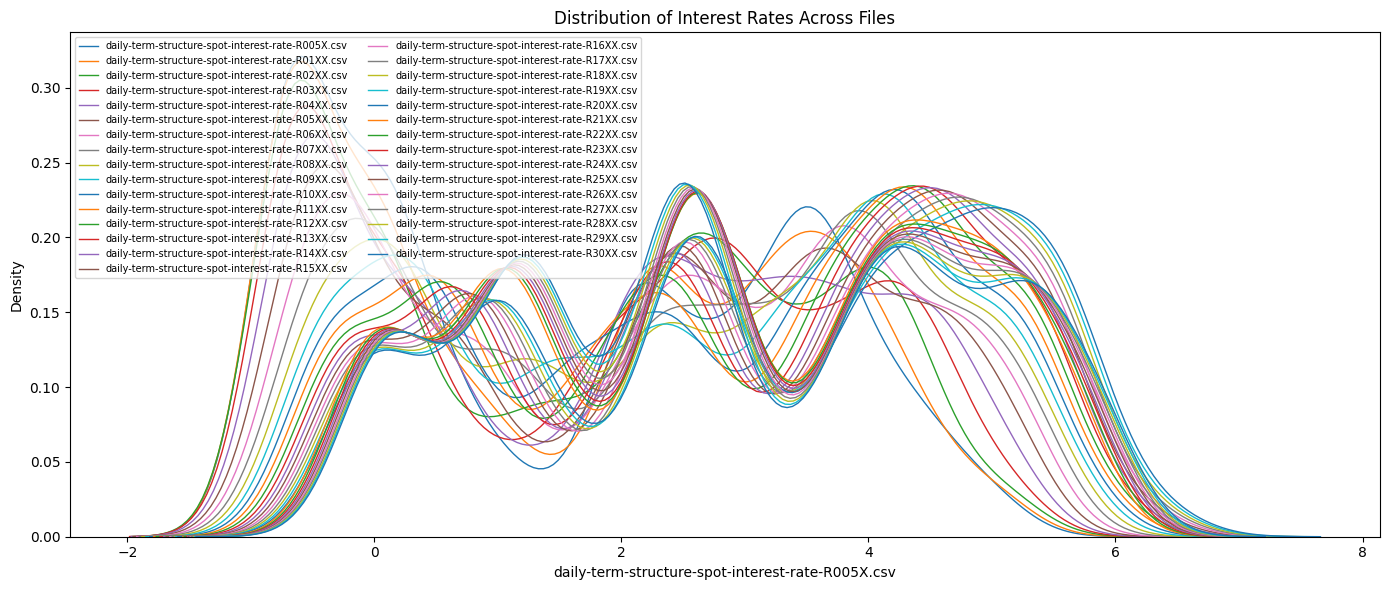

In [ ]:
plt.figure(figsize=(14, 6))
for i, col in enumerate(merged_df.columns[1:]):
    sns.kdeplot(data=merged_df[col], label=col, linewidth=1)
plt.title("Distribution of Interest Rates Across Files")
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()


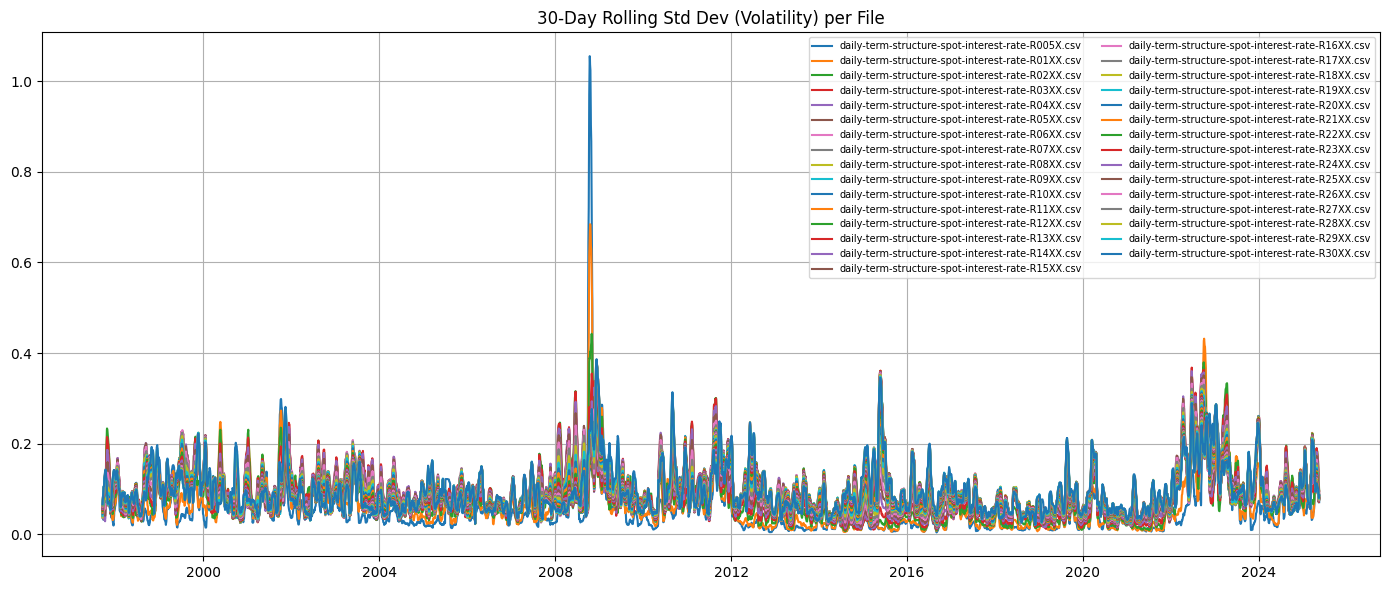

In [ ]:
plt.figure(figsize=(14, 6))
for col in merged_df.columns[1:]:
    rolling_std = merged_df[col].rolling(window=30).std()
    plt.plot(merged_df['Date'], rolling_std, label=col)
plt.title("30-Day Rolling Std Dev (Volatility) per File")
plt.legend(fontsize=7, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
